<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>

Author: Jakub Pyszniak

Notebook 2

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import math

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy as bp

# Visual set-up
pd.set_option("display.max_columns", 60)

# Importing data

In [3]:
df = pd.read_csv("2.processed_data/preprocessed_dataset_for_models.csv")

# Setting categorical variables
df["product_category_name_english"] = df["product_category_name_english"].astype("category")
df["seller_state"] = df["seller_state"].astype("category")
df["customer_state"] = df["customer_state"].astype("category")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  float64 
 1   order_item_id                  91475 non-null  int64   
 2   total_price                    91475 non-null  float64 
 3   total_freight                  91475 non-null  float64 
 4   order_value_check              91475 non-null  float64 
 5   is_payment_sequential_1        91475 non-null  float64 
 6   payment_type_boleto            91475 non-null  float64 
 7   payment_type_credit_card       91475 non-null  float64 
 8   payment_type_debit_card        91475 non-null  float64 
 9   payment_type_voucher           91475 non-null  float64 
 10  installments_boleto            91475 non-null  float64 
 11  installments_credit_card       91475 non-null  float64 
 12  installments_debit_card        9

delay_days  order_item_id  total_price  total_freight  order_value_check  \
0        -8.0              1        29.99           8.72              38.71   
1        -6.0              1       118.70          22.76             141.46   
2       -18.0              1       159.90          19.22             179.12   
3       -13.0              1        45.00          27.20              72.20   
4       -10.0              1        19.90           8.72              28.62   

   is_payment_sequential_1  payment_type_boleto  payment_type_credit_card  \
0                      1.0                  0.0                       1.0   
1                      1.0                  1.0                       0.0   
2                      1.0                  0.0                       1.0   
3                      1.0                  0.0                       1.0   
4                      1.0                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  ...  seller_lng  \
0                      0.0                   0.0  ...  -46.452454   
1                      0.0                   0.0  ...  -43.984727   
2                      0.0                   0.0  ...  -48.232976   
3                      0.0                   0.0  ...  -43.923299   
4                      0.0                   0.0  ...  -46.260979   

   cust_sell_distance_km  order_purchase_month  order_delivery_month  \
0              18.063837                    10                    10   
1             856.292580                     7                     8   
2             514.130333                     8                     8   
3            1822.800366                    11                    12   
4              30.174037                     2                     2   

   order_year_2016  order_year_2017  order_year_2018  delivery_year_2016  \
0                0                1                0                   0   
1                0                0                1                   0   
2                0                0                1                   0   
3                0                1                0                   0   
4                0                0                1                   0   

   delivery_year_2017  delivery_year_2018  
0                   1                   0  
1                   0                   1  
2                   0                   1  
3                   1                   0  
4                   0                   1  

[5 rows x 38 columns]

# EDA

We will borrow a convenient function from [ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates GitHub project](https://github.com/michaelwozniak/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates) (with some modifications) which will simultaneously draw a histogram, boxplot and a scatter plot of our features against our target (delay_days)

In [4]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=True, stat="density") # modifications regarding how bins are constructed (represent density) 
                                                            # and an actual Kerned density overlay
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.delay_days
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df.delay_days)
    plt.plot()

# For categorical/count data
def quick_viz_cat(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=True, discrete=True) # modifications regarding how bins are constructed (represent density) 
                                                            # and an actual Kerned density overlay
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.delay_days
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df.delay_days)
    plt.plot()    


# For 4 variables at once
def quick_viz_4(df, vars4, y_col="delay_days"):
    """
    vars4: list/tuple of exactly 4 column names (strings) in df
    y_col: target column for scatterplots (default: 'delay_days')
    """
    if len(vars4) != 4:
        raise ValueError("vars4 must contain exactly 4 variable names.")

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))

    for i, col in enumerate(vars4):
        x = df[col]

        # 1) histogram + KDE
        ax = axes[i, 0]
        sns.histplot(x=x, kde=True, stat="density", ax=ax)
        ax.set_title(f"{col}: Hist (density) + KDE")
        ax.set_xlabel("")
        ax.set_ylabel("")

        # 2) boxplot
        ax = axes[i, 1]
        sns.boxplot(x=x, ax=ax)
        ax.set_title(f"{col}: Boxplot")
        ax.set_xlabel("")
        ax.set_yticks([])  # optional: cleaner since it's a 1D boxplot

        # 3) scatter vs y_col
        ax = axes[i, 2]
        sns.scatterplot(x=x, y=df[y_col], ax=ax, s=12)
        ax.set_title(f"{col} vs {y_col}")
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

# A dynamic version
def quick_viz_grid(df, vars_list, y_col="delay_days"):
    """
    vars_list: list/tuple of column names in df (e.g., 2–4 variables, but works for any >=1)
    y_col: target column for scatterplots (default: 'delay_days')
    """
    if not isinstance(vars_list, (list, tuple)) or len(vars_list) == 0:
        raise ValueError("vars_list must be a non-empty list/tuple of column names.")

    n = len(vars_list)
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(18, 4 * n))

    # If n == 1, axes comes back 1D; make it 2D for consistent indexing
    if n == 1:
        axes = axes.reshape(1, 3)

    for i, col in enumerate(vars_list):
        x = df[col]

        # 1) histogram + KDE
        ax = axes[i, 0]
        sns.histplot(x=x, kde=True, stat="density", ax=ax)
        ax.set_title(f"{col}: Hist (density) + KDE")
        ax.set_xlabel("")
        ax.set_ylabel("")

        # 2) boxplot
        ax = axes[i, 1]
        sns.boxplot(x=x, ax=ax)
        ax.set_title(f"{col}: Boxplot")
        ax.set_xlabel("")
        ax.set_yticks([])

        # 3) scatter vs y_col
        ax = axes[i, 2]
        sns.scatterplot(x=x, y=df[y_col], ax=ax, s=12)
        ax.set_title(f"{col} vs {y_col}")
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


# Individual feature analysis

> In this section we will make sure that our variables are transformed if needed, and we will try to understand the qualities of each variable

**order_item_id**

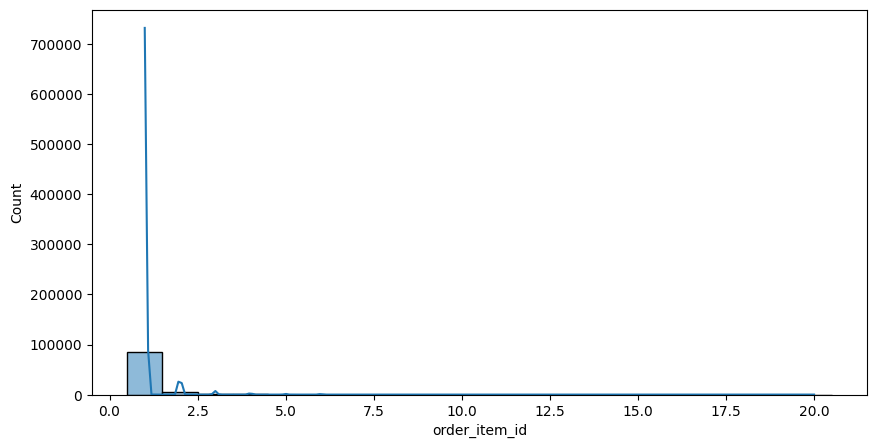

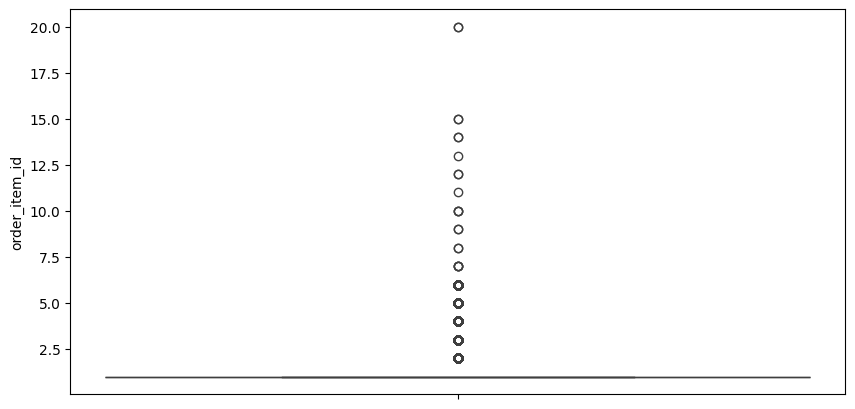

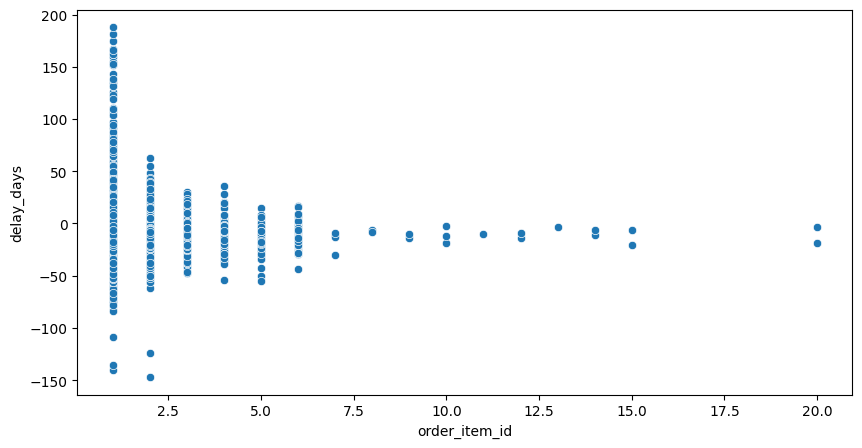

In [5]:
quick_viz_cat(df.order_item_id)

Hardly a relationship

**total price**

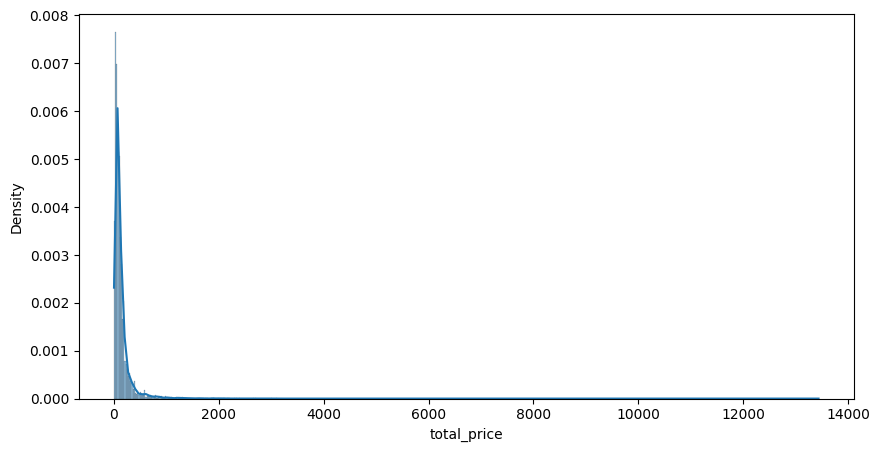

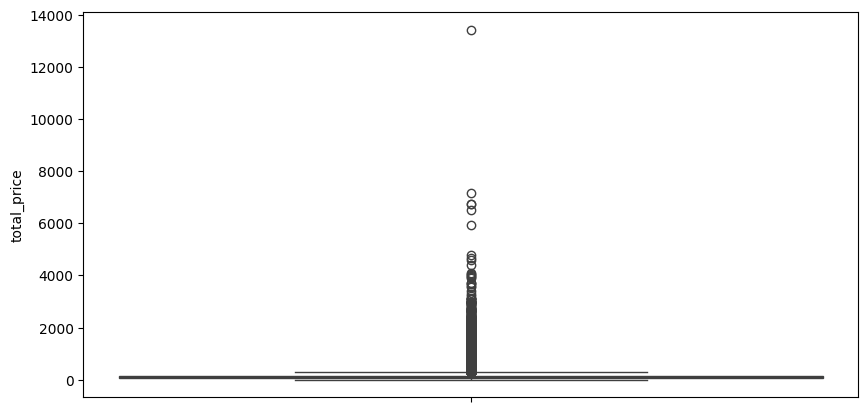

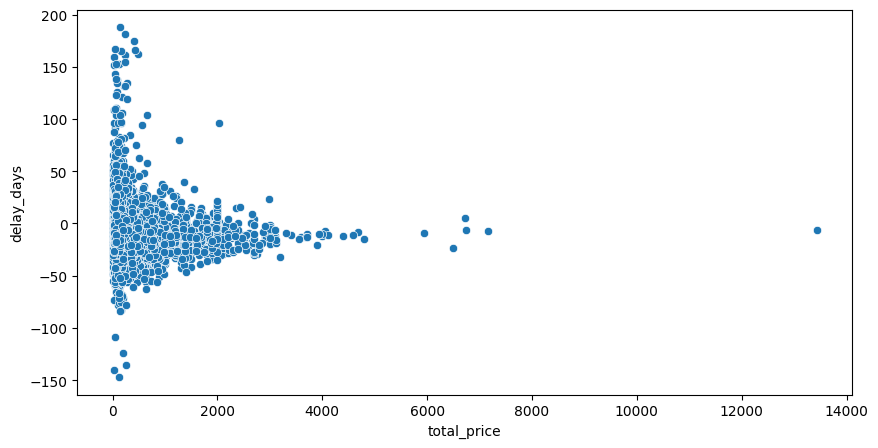

In [6]:
quick_viz(df.total_price)

Very skewed and likely some outliers. Clearly not a linear relationship with our target

> Could a log transform be useful?

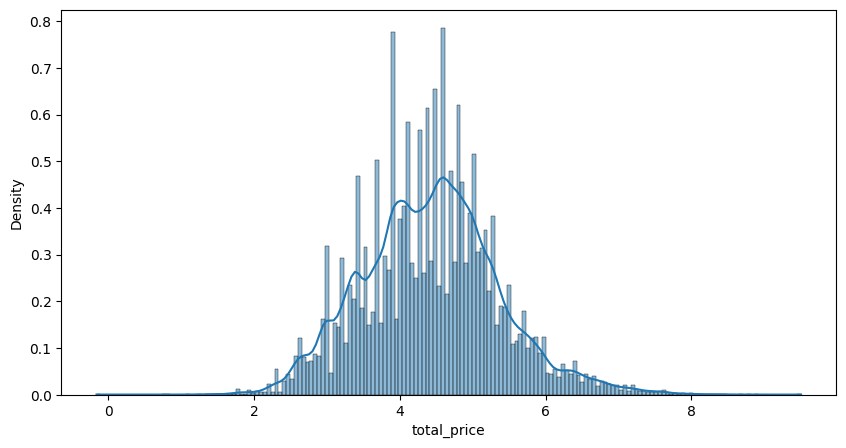

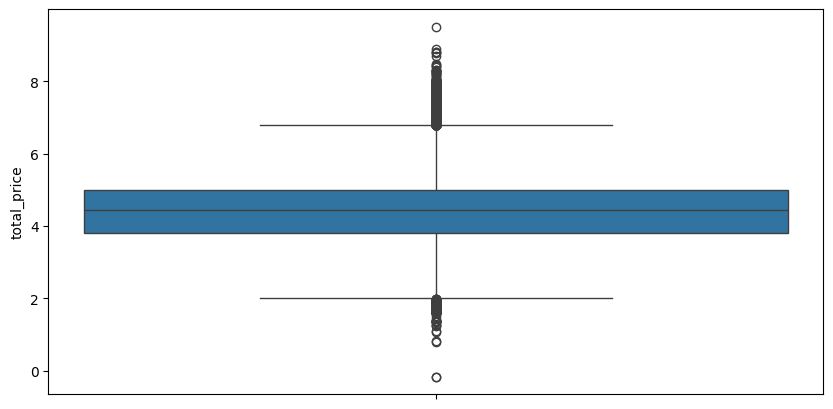

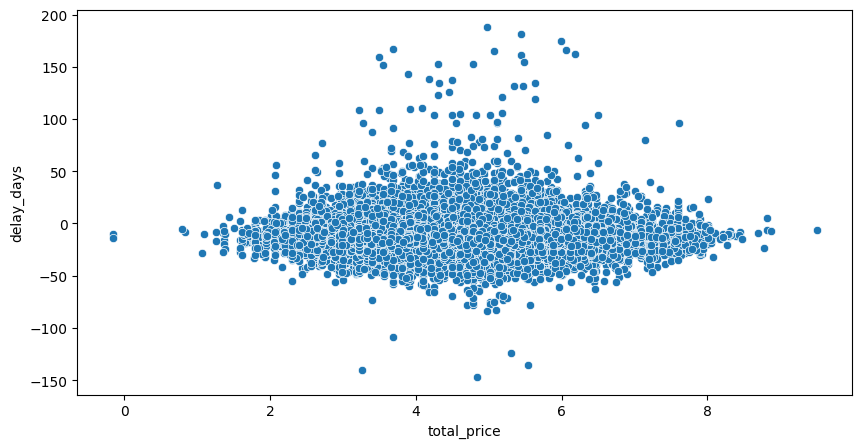

In [7]:
quick_viz(np.log(df.total_price))

Possibly better but we see that there is almost no relation between our feature and target. Let's add it for now

In [8]:
df["total_price_log"] = np.log(df.total_price)

**total_freight**

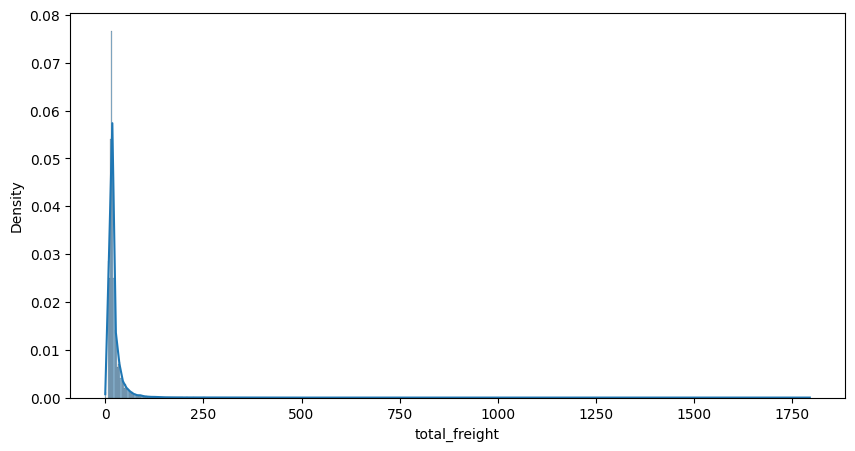

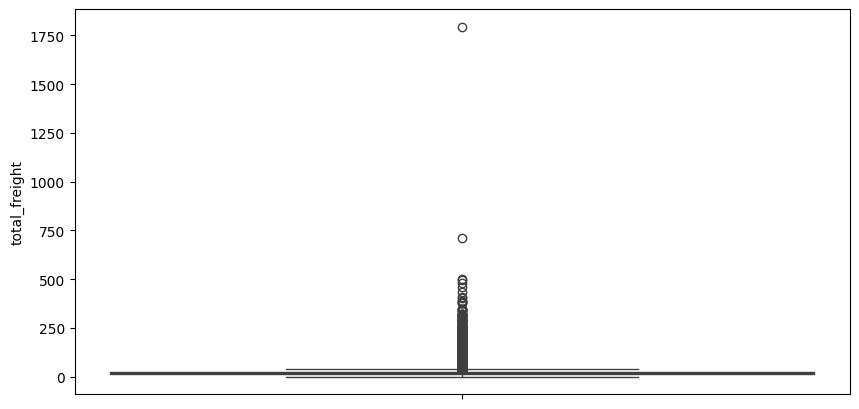

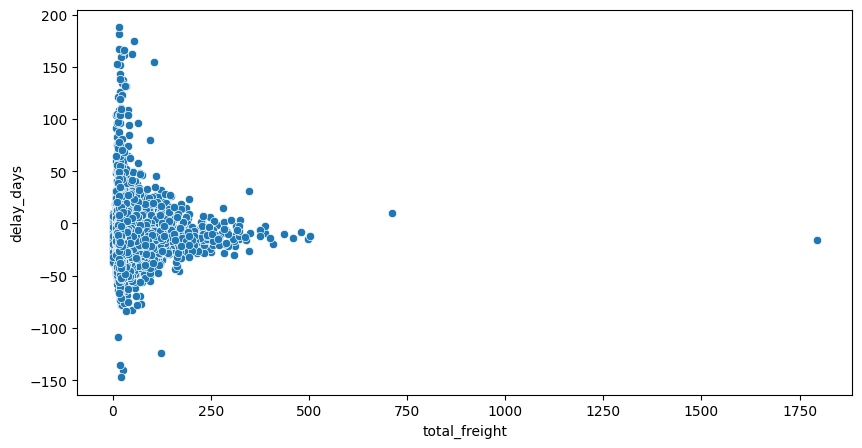

In [9]:
quick_viz(df.total_freight)

In [10]:
df.total_freight.describe()

count    91475.000000
mean        22.093803
std         20.363560
min          0.000000
25%         13.690000
50%         16.950000
75%         23.280000
max       1794.960000
Name: total_freight, dtype: float64

In [11]:
df[df["total_freight"]==0].head()

delay_days  order_item_id  total_price  total_freight  order_value_check  \
180       -21.0              2        139.8            0.0              139.8   
384       -29.0              1         99.9            0.0               99.9   
595        -4.0              1         69.9            0.0               69.9   
613       -13.0              1        110.0            0.0              110.0   
800       -16.0              1         69.9            0.0               69.9   

     is_payment_sequential_1  payment_type_boleto  payment_type_credit_card  \
180                      1.0                  0.0                       1.0   
384                      1.0                  0.0                       1.0   
595                      1.0                  1.0                       0.0   
613                      1.0                  0.0                       1.0   
800                      1.0                  0.0                       1.0   

     payment_type_debit_card  payment_type_voucher  ...  \
180                      0.0                   0.0  ...   
384                      0.0                   0.0  ...   
595                      0.0                   0.0  ...   
613                      0.0                   0.0  ...   
800                      0.0                   0.0  ...   

     cust_sell_distance_km  order_purchase_month  order_delivery_month  \
180             481.457016                     4                     4   
384             516.103793                     5                     5   
595             852.595287                     5                     6   
613            2122.402326                     5                     5   
800             328.079227                     4                     5   

     order_year_2016  order_year_2017  order_year_2018  delivery_year_2016  \
180                0                0                1                   0   
384                0                0                1                   0   
595                0                0                1                   0   
613                0                0                1                   0   
800                0                0                1                   0   

     delivery_year_2017  delivery_year_2018  total_price_log  
180                   0                   1         4.940213  
384                   0                   1         4.604170  
595                   0                   1         4.247066  
613                   0                   1         4.700480  
800                   0                   1         4.247066  

[5 rows x 39 columns]

We seem to have an issue where our total freight is equal to 0 in some places. We will leave it as it could contain important information but this means that we can't use the log transform

**order_value_check**

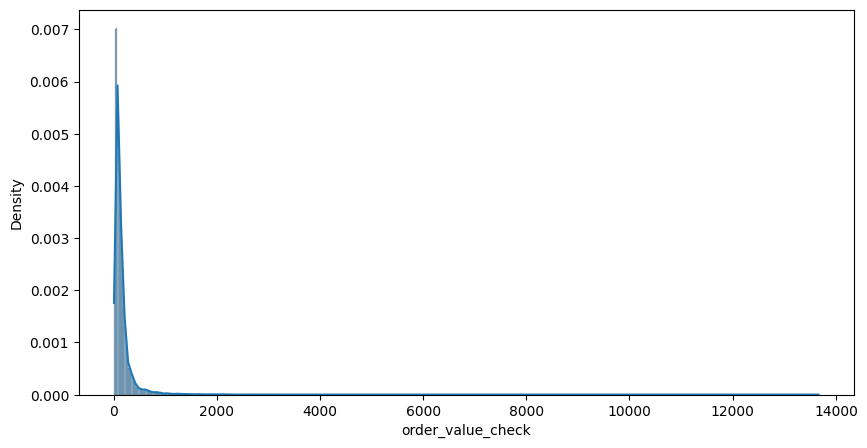

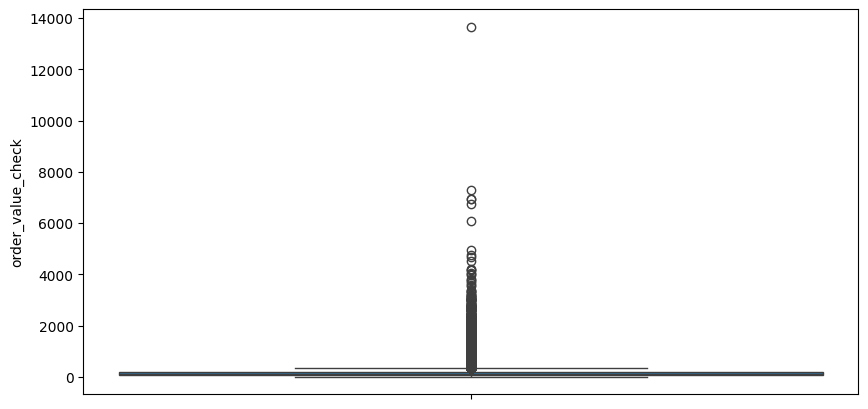

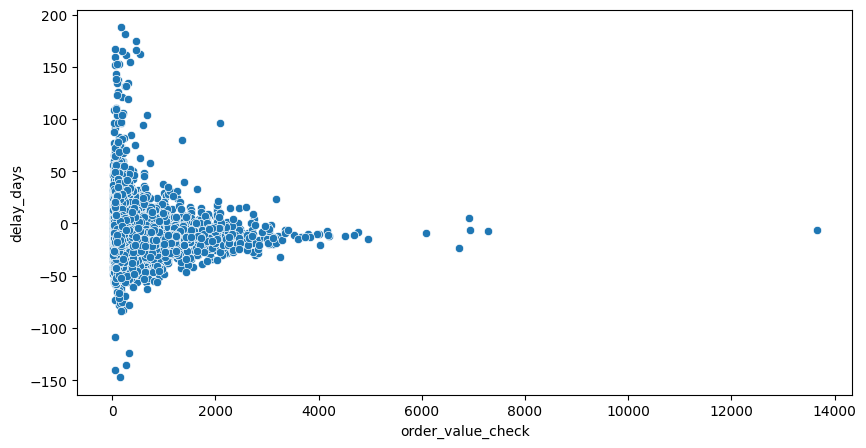

In [12]:
quick_viz(df.order_value_check)

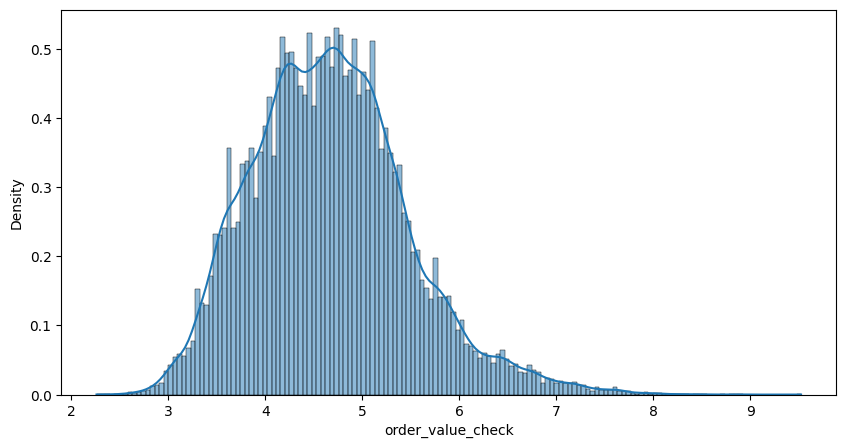

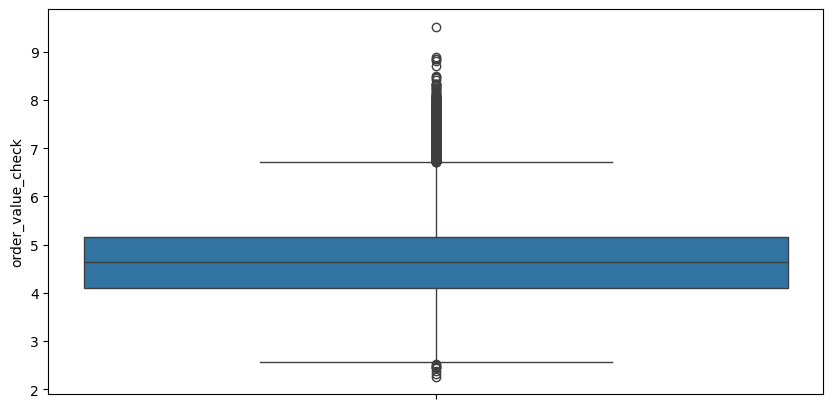

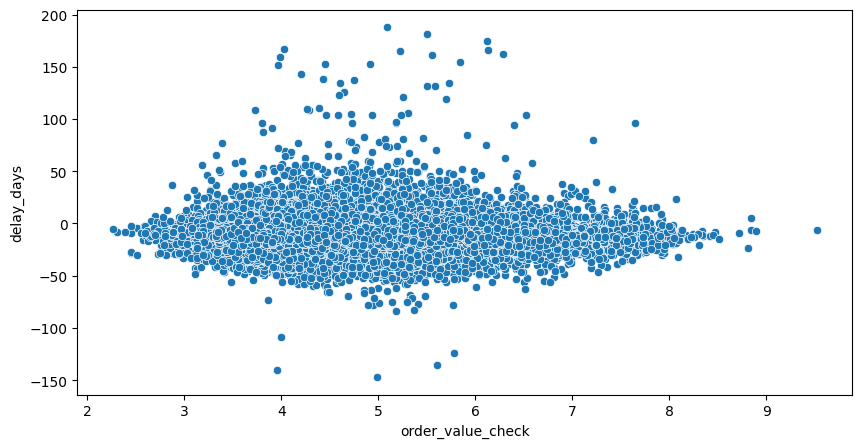

In [13]:
quick_viz(np.log(df.order_value_check))

> We could try a Robust Scaler as well to account for the outliers

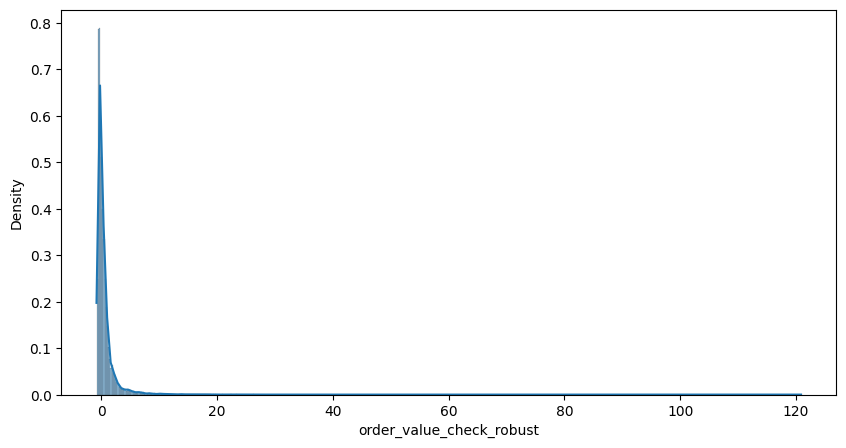

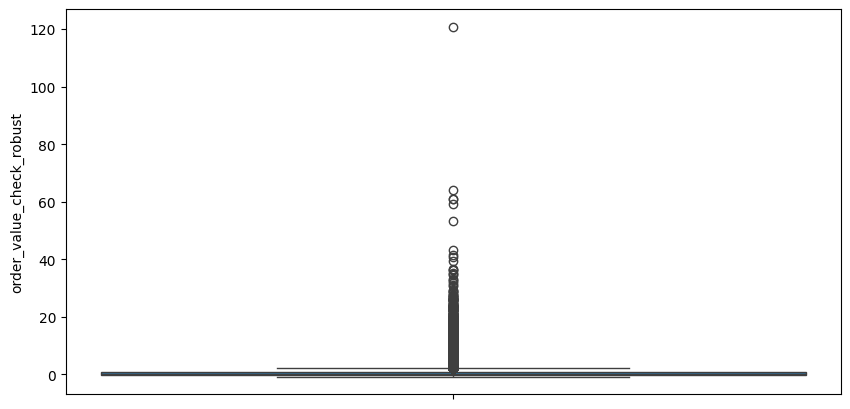

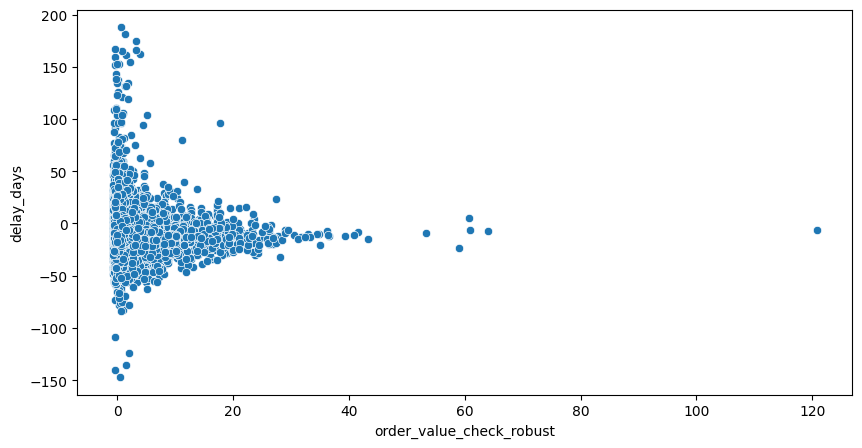

In [14]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df["order_value_check_robust"] = scaler.fit_transform(df[["order_value_check"]])

quick_viz(df.order_value_check_robust)

Doesn't seem to have helped

In [15]:
df = df.drop(columns = ["order_value_check_robust"])

df["order_value_check_log"] = np.log(df.order_value_check)

In [16]:
df.info() # quick check to see if everything is good so far

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  float64 
 1   order_item_id                  91475 non-null  int64   
 2   total_price                    91475 non-null  float64 
 3   total_freight                  91475 non-null  float64 
 4   order_value_check              91475 non-null  float64 
 5   is_payment_sequential_1        91475 non-null  float64 
 6   payment_type_boleto            91475 non-null  float64 
 7   payment_type_credit_card       91475 non-null  float64 
 8   payment_type_debit_card        91475 non-null  float64 
 9   payment_type_voucher           91475 non-null  float64 
 10  installments_boleto            91475 non-null  float64 
 11  installments_credit_card       91475 non-null  float64 
 12  installments_debit_card        9

**is_payment_sequential_1**

In [17]:
df.is_payment_sequential_1.nunique()

2

In [18]:
df.is_payment_sequential_1.value_counts()

is_payment_sequential_1
1.0    89995
0.0     1480
Name: count, dtype: int64

In [19]:
df["is_payment_sequential_1"] = df["is_payment_sequential_1"].astype(bool) # to make it more clean

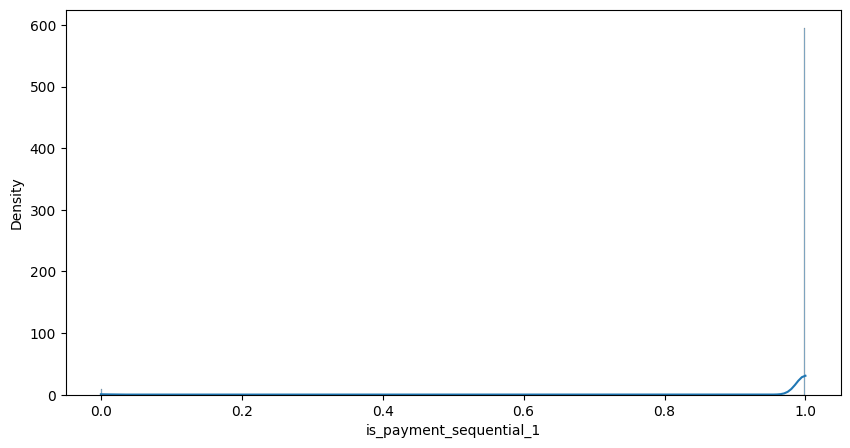

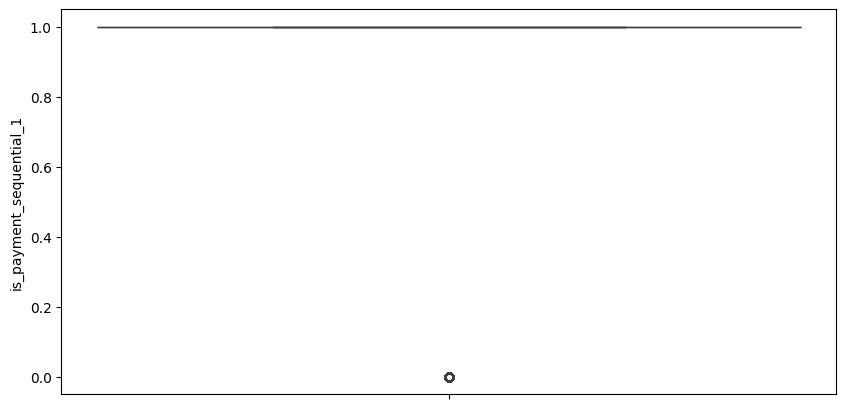

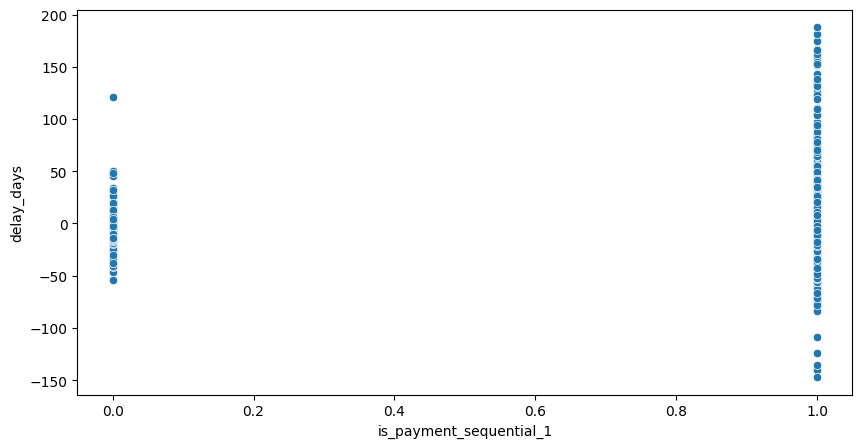

In [20]:
quick_viz(df.is_payment_sequential_1)

> This is very unbalanced - we may require a stratified - k fold approach in CV later. Either we can't say much about this variable or it's clear that if an order was paid for with many methods, then we experience more extreme delays.

**payment_type_boleto**

In [21]:
df.payment_type_boleto.nunique()

2

In [22]:
df["payment_type_boleto"] = df["payment_type_boleto"].astype(bool) # to make it more clean

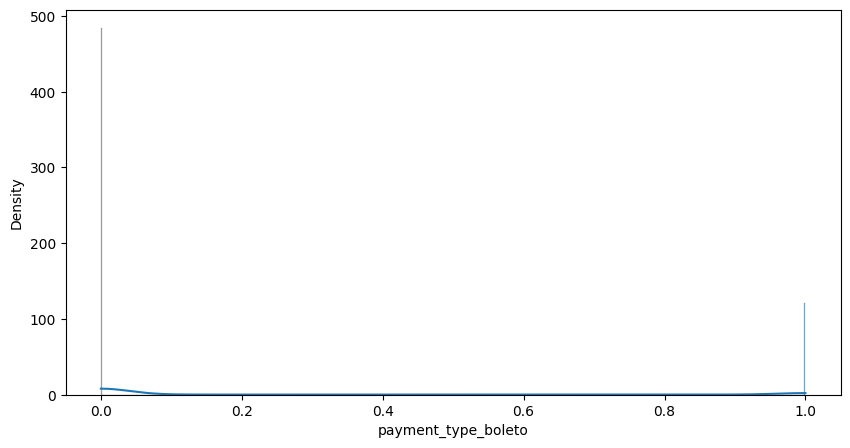

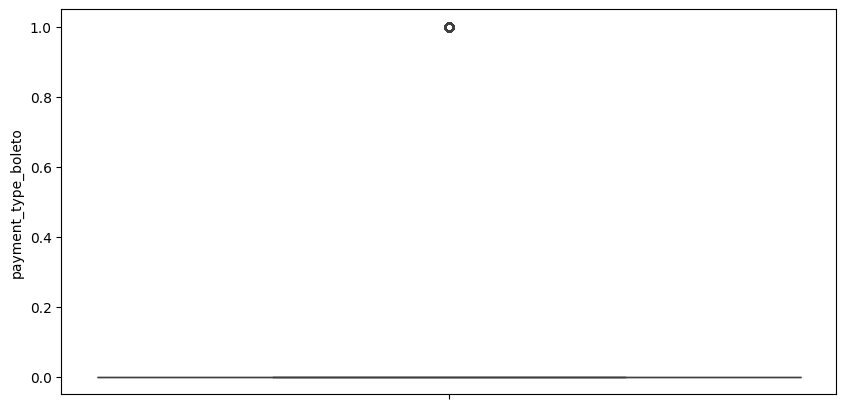

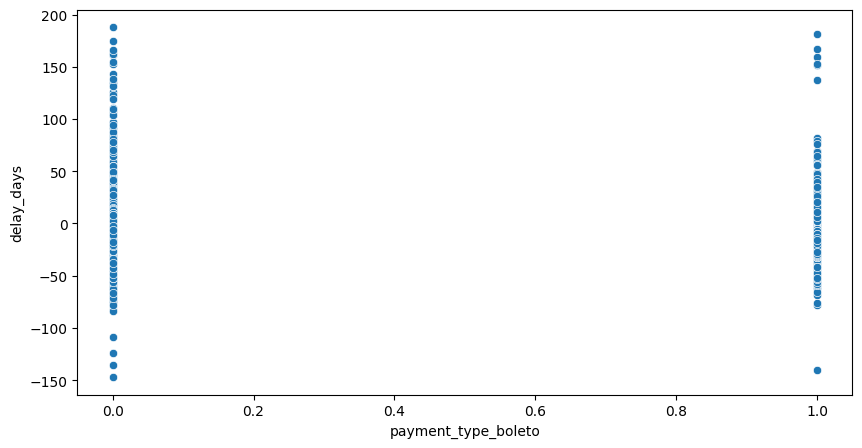

In [23]:
quick_viz(df.payment_type_boleto)

Again, not much to say here

**payment_type_credit_card**

In [24]:
df.payment_type_credit_card.nunique()

2

In [25]:
df["payment_type_credit_card"] = df["payment_type_credit_card"].astype(bool) # to make it more clean

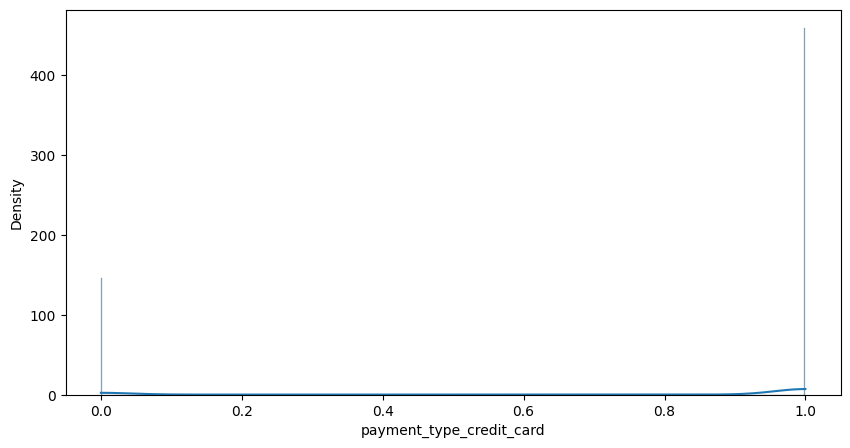

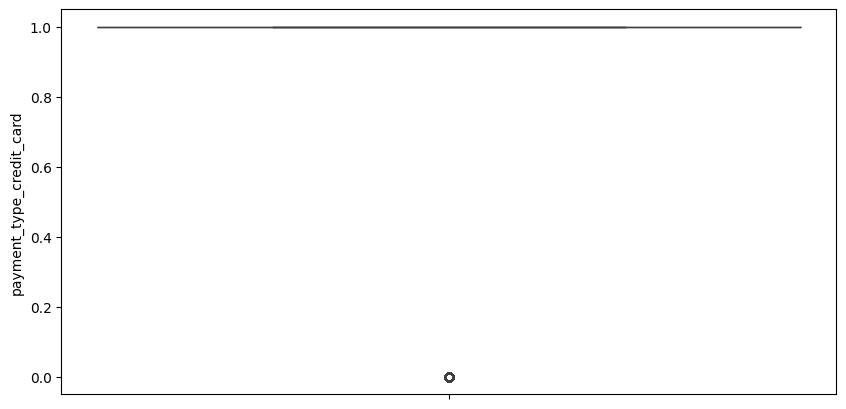

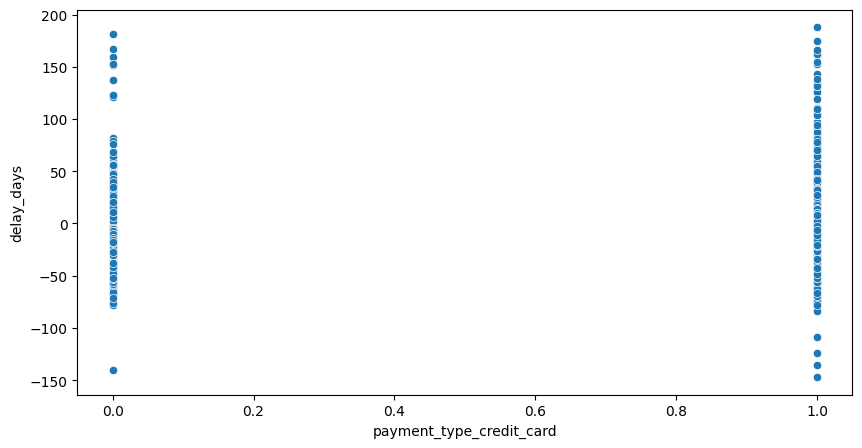

In [26]:
quick_viz(df.payment_type_credit_card)

In [27]:
df.payment_type_credit_card.value_counts()

payment_type_credit_card
True     69351
False    22124
Name: count, dtype: int64

Similar situation here as well

**payment_type_debit_card**

In [28]:
df.payment_type_debit_card.nunique()

2

In [29]:
df["payment_type_debit_card"] = df["payment_type_debit_card"].astype(bool) # to make it more clean

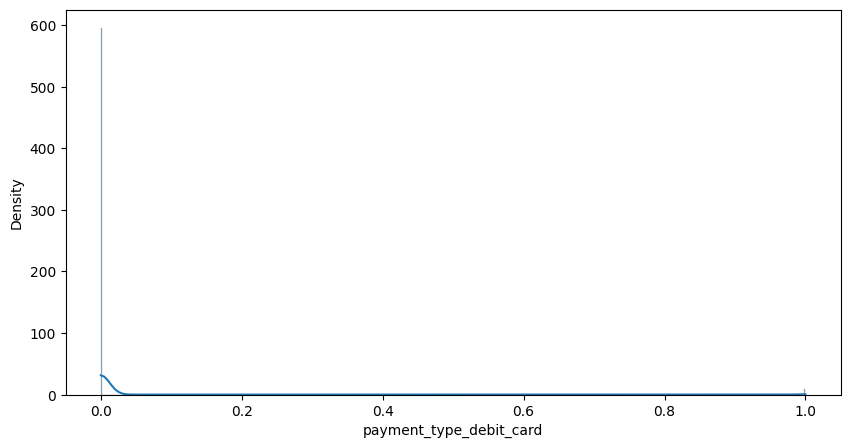

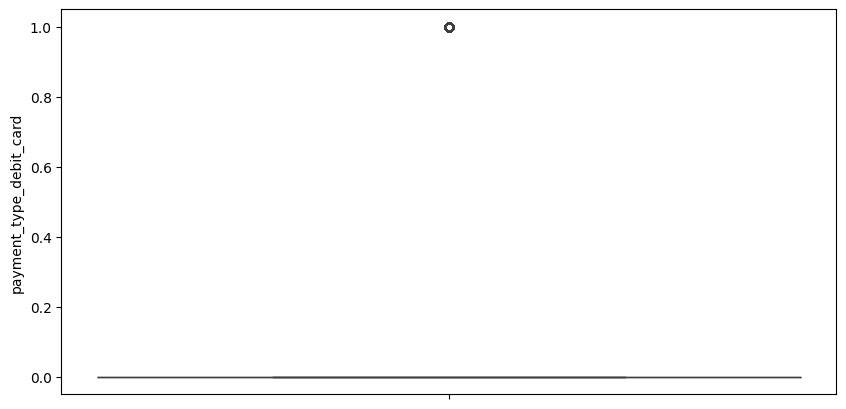

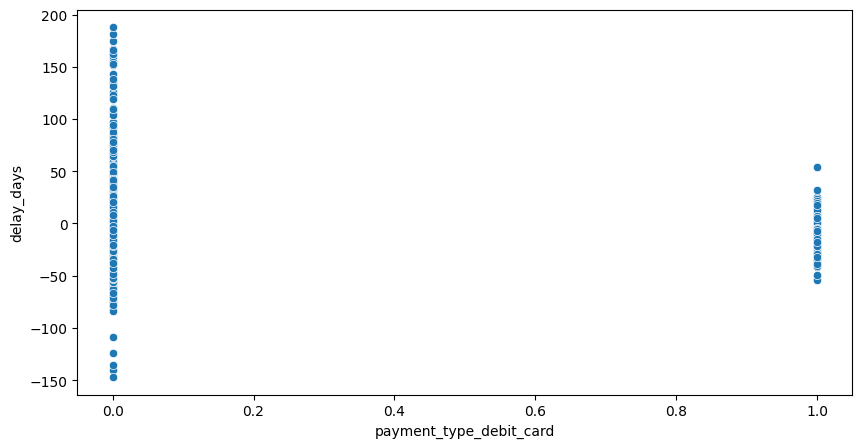

In [30]:
quick_viz(df.payment_type_debit_card)

> Smaller delays when the order is paid by debit card?

**payment_type_voucher**

In [31]:
df.payment_type_voucher.nunique()

2

In [32]:
df["payment_type_voucher"] = df["payment_type_voucher"].astype(bool) # to make it more clean

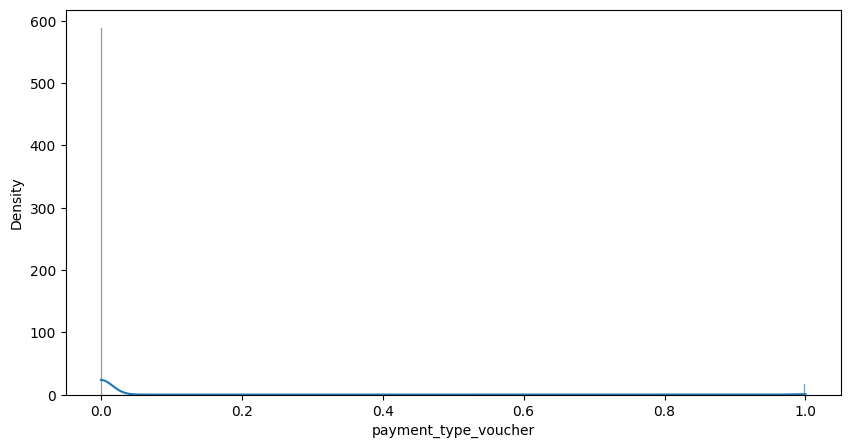

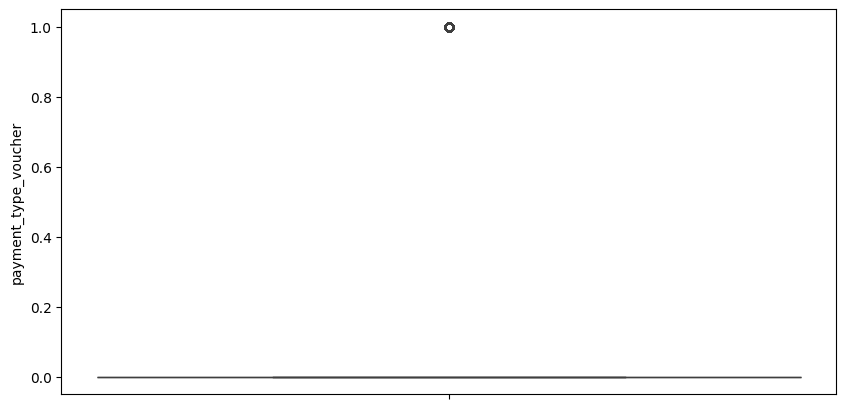

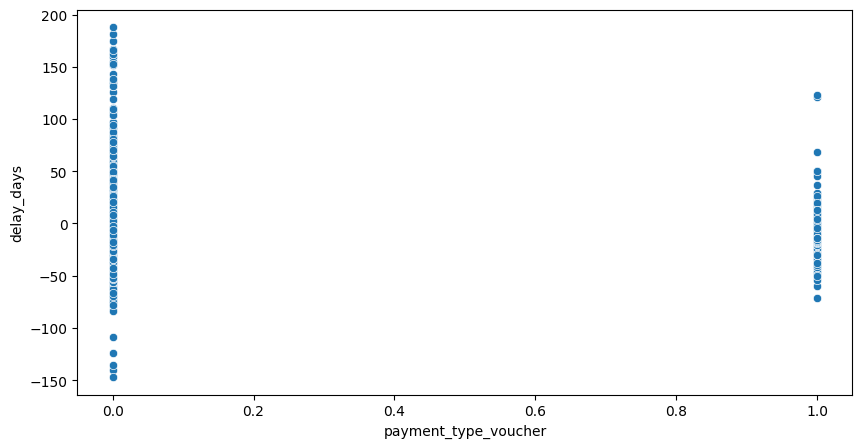

In [33]:
quick_viz(df.payment_type_voucher)

In [34]:
df.payment_type_voucher.value_counts()

payment_type_voucher
False    89024
True      2451
Name: count, dtype: int64

Similarily to the previous variable but we also have to keep in mind that this is imbalanced

**installments_boleto**

In [35]:
df.installments_boleto.nunique()

2

In [36]:
df.installments_boleto.value_counts()

installments_boleto
0.0    73204
1.0    18271
Name: count, dtype: int64

In [37]:
df["installments_boleto"] = df["installments_boleto"].astype(int) # to make it more clean

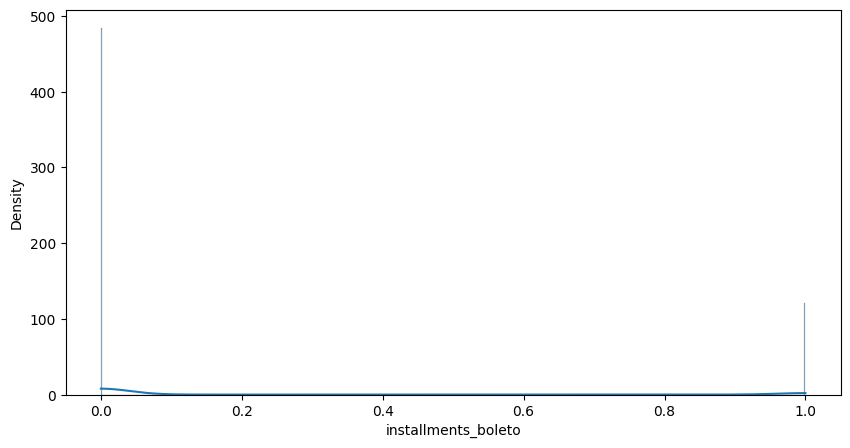

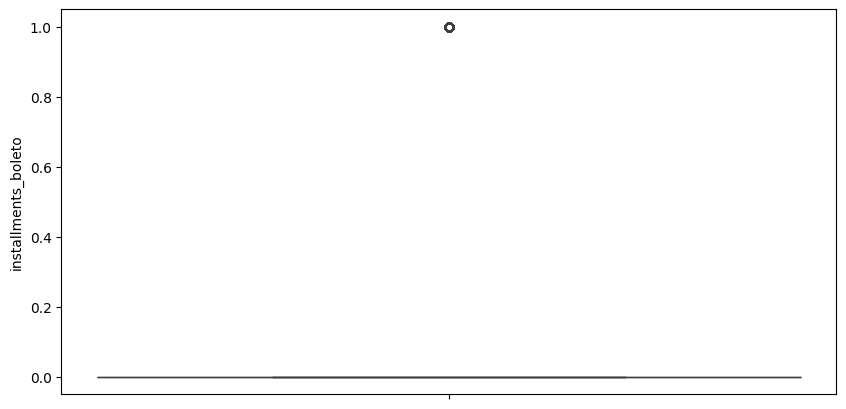

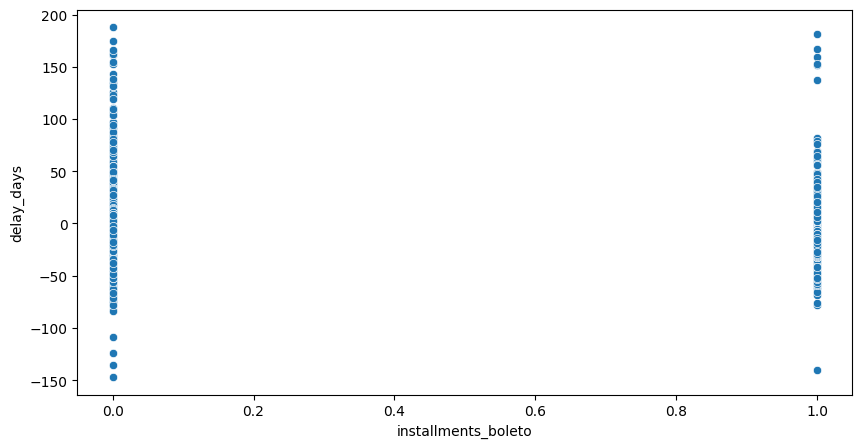

In [38]:
quick_viz(df.installments_boleto)

Very similar behaviour

**installments_credit_card**

In [39]:
df.installments_credit_card.nunique()

24

In [40]:
df["installments_credit_card"] = df["installments_credit_card"].astype(int) # to make it more clean

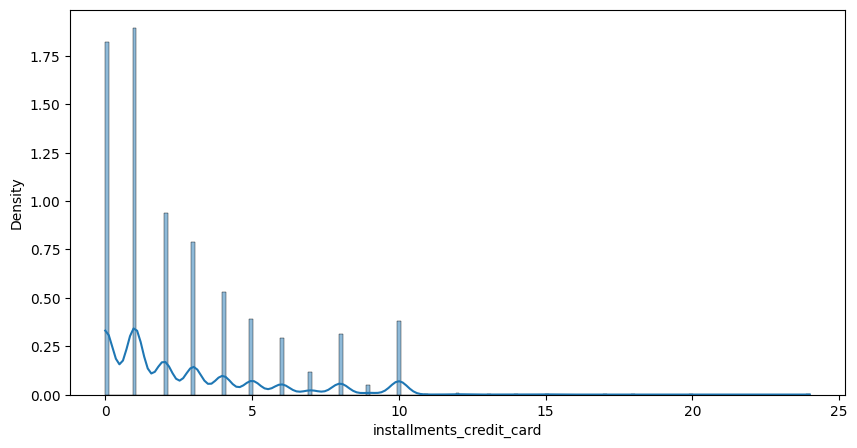

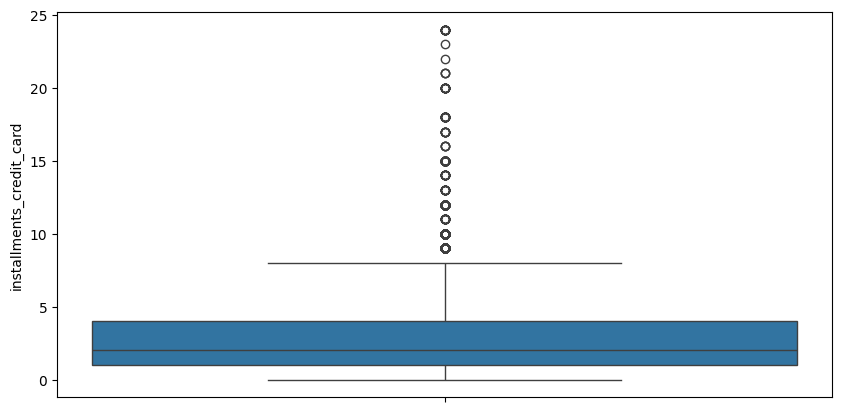

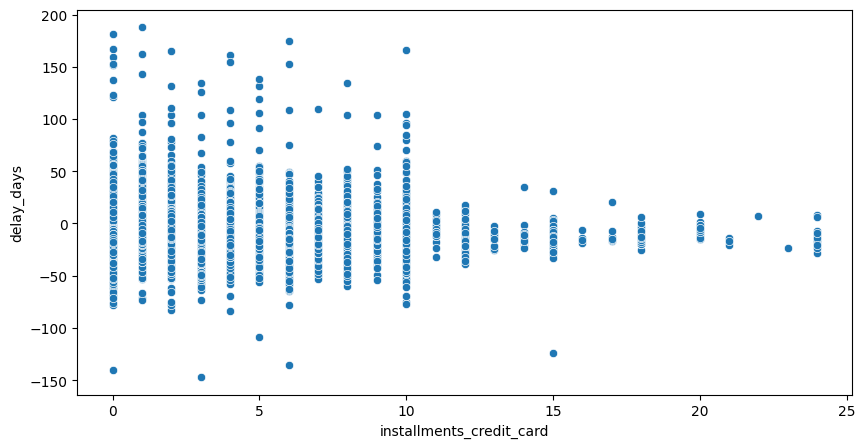

In [41]:
quick_viz(df.installments_credit_card)

In [42]:
df.installments_credit_card.value_counts()

installments_credit_card
1     22986
0     22126
2     11363
3      9557
4      6450
5      4735
10     4630
8      3792
6      3521
7      1445
9       576
12      112
15       66
18       25
11       19
24       15
20       14
13       14
14       13
17        7
16        4
21        3
23        1
22        1
Name: count, dtype: int64

**installments_debit_card**

In [43]:
df.installments_debit_card.nunique()

2

In [44]:
df["installments_debit_card"] = df["installments_debit_card"].astype(int) # to make it more clean

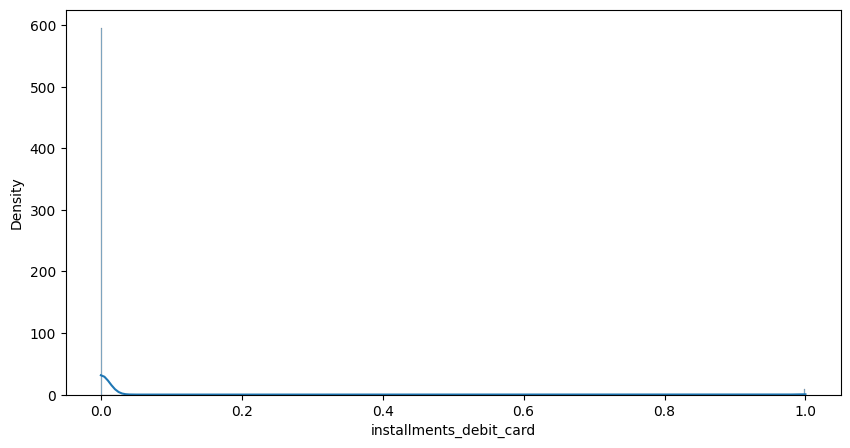

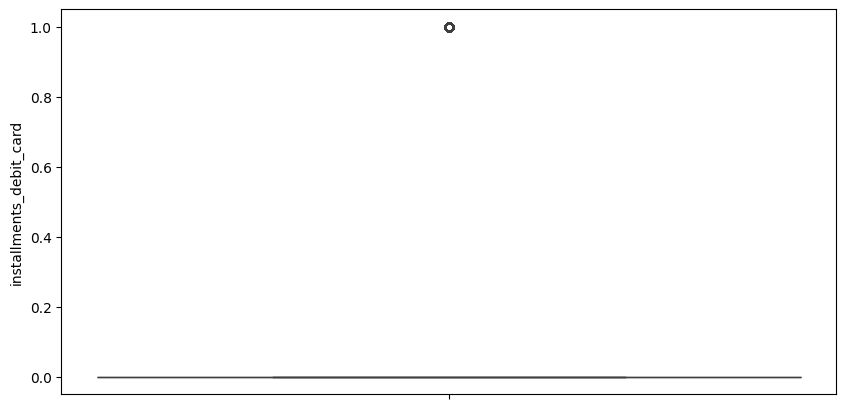

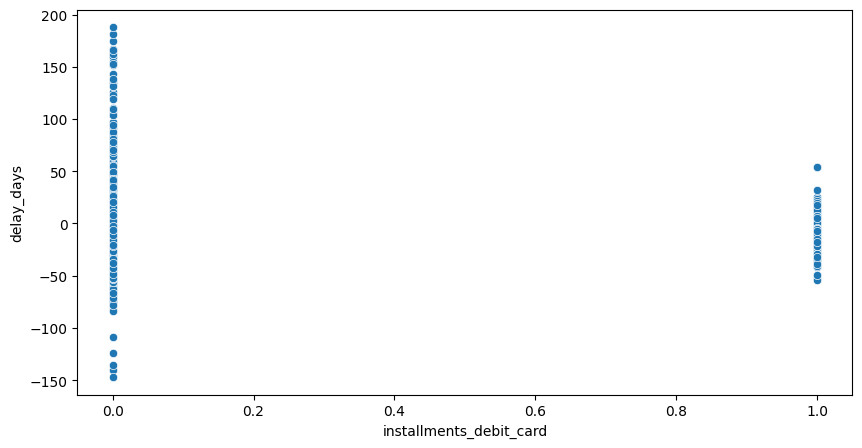

In [45]:
quick_viz(df.installments_debit_card)

**isnstallments_voucher**

In [46]:
df.installments_voucher.nunique()

2

In [47]:
df["installments_voucher"] = df["installments_voucher"].astype(int) # to make it more clean

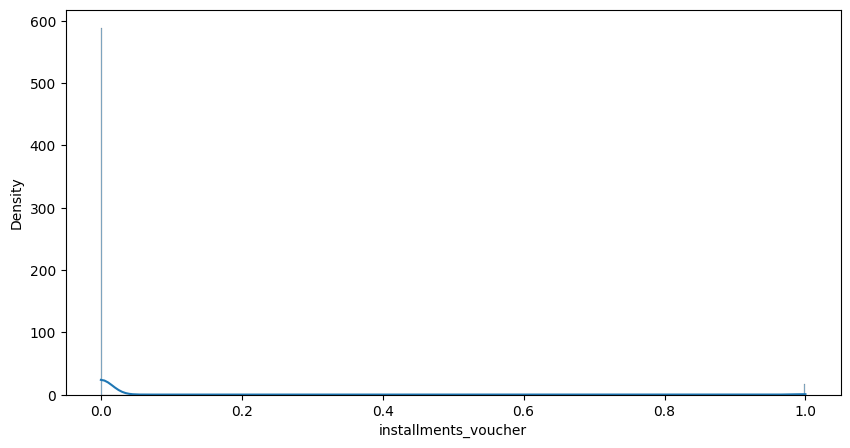

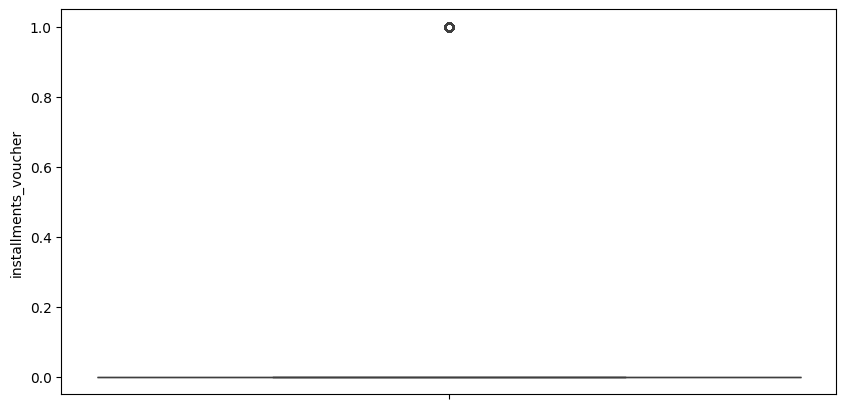

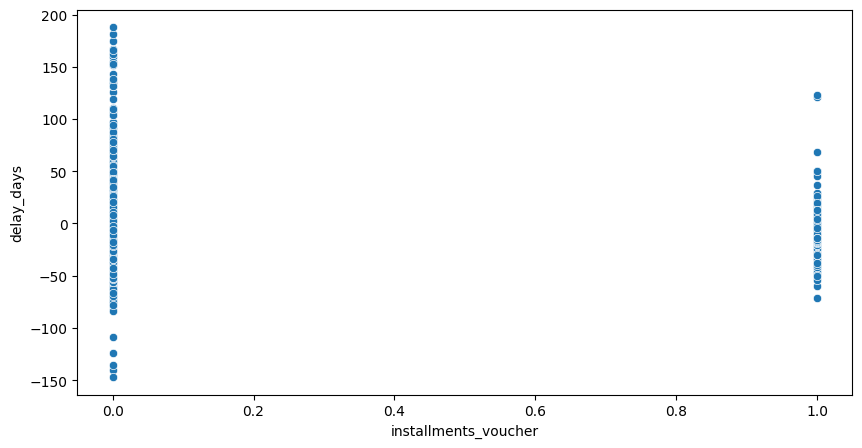

In [48]:
quick_viz(df.installments_voucher)

**product_name_lenght**

Let's fix the typo first

In [49]:
df.rename(columns={"product_name_lenght": "product_name_length"}, inplace=True)

In [50]:
df.product_name_length.nunique()

64

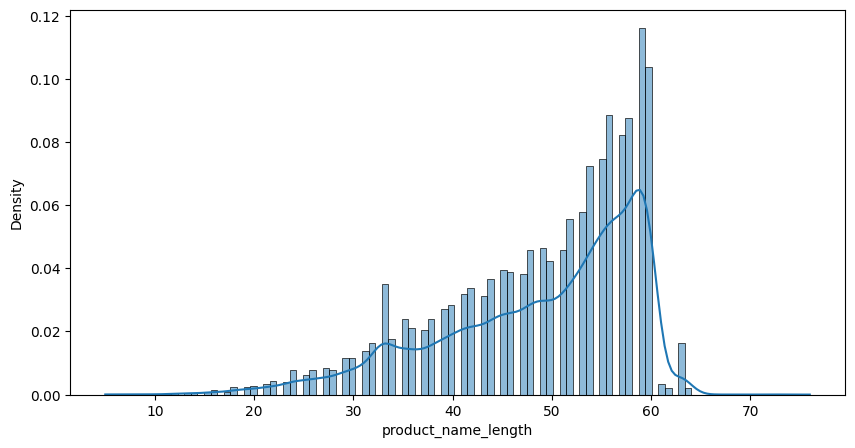

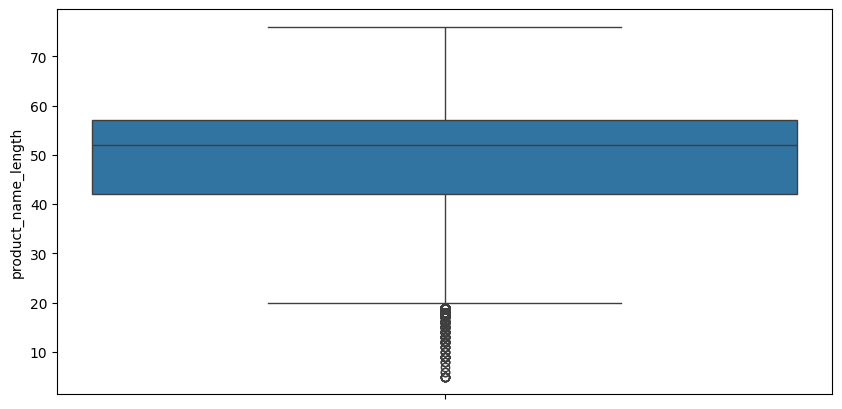

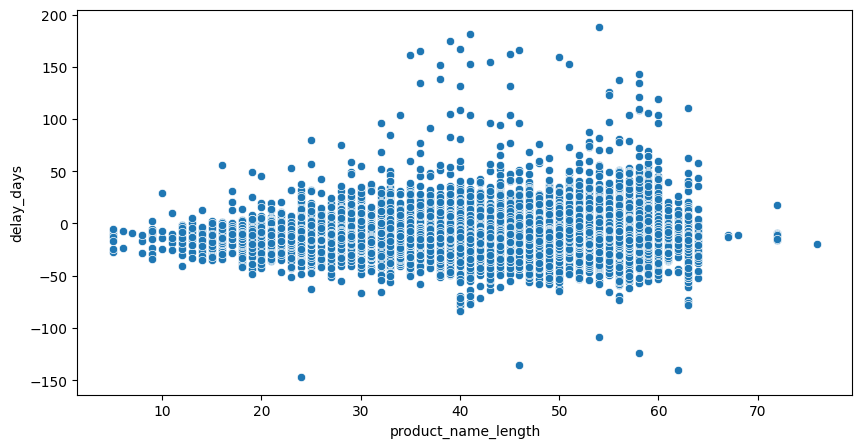

In [51]:
quick_viz(df.product_name_length)

The relationship seems vague again

**product_description_lenght**

In [52]:
df.rename(columns={"product_description_lenght": "product_description_length"}, inplace=True)

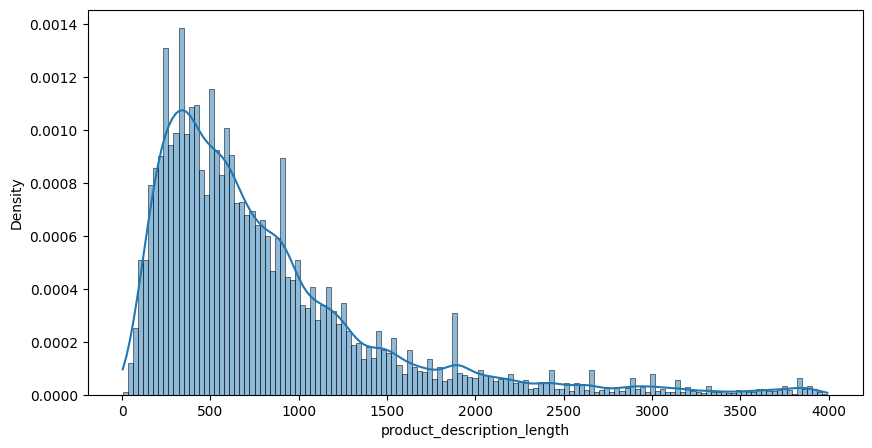

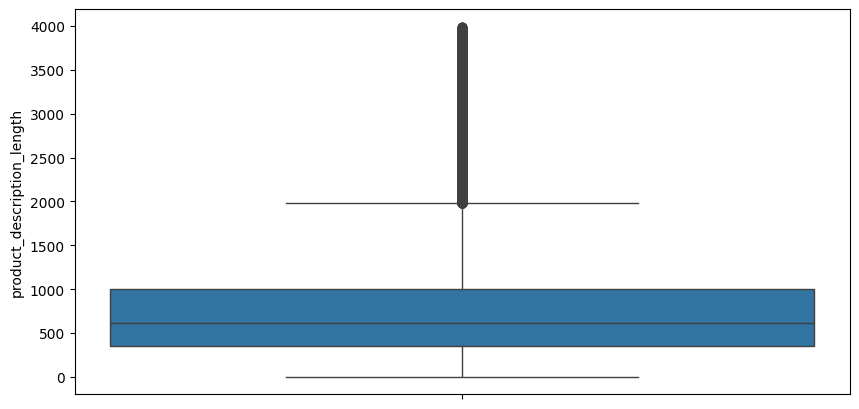

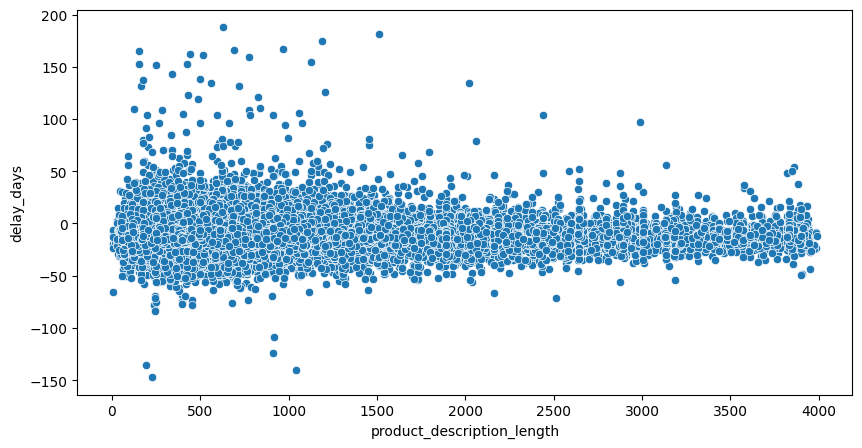

In [53]:
quick_viz(df.product_description_length)

**product_photos_qty**

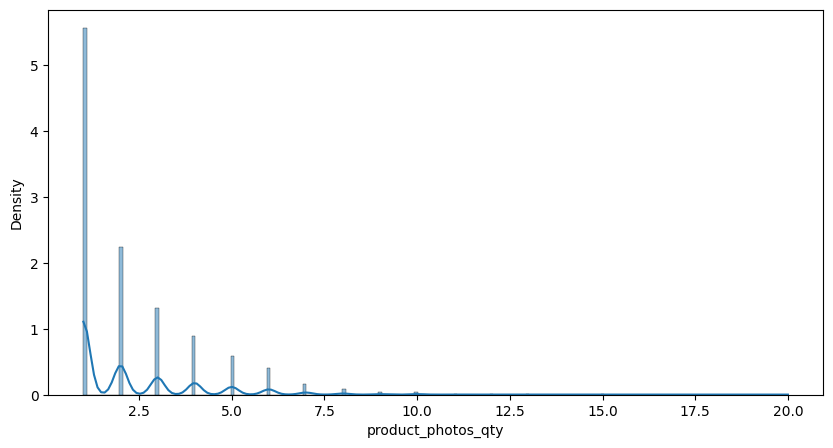

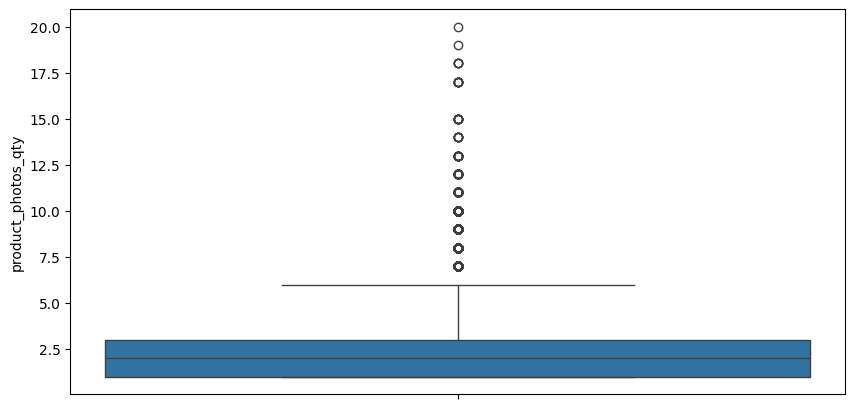

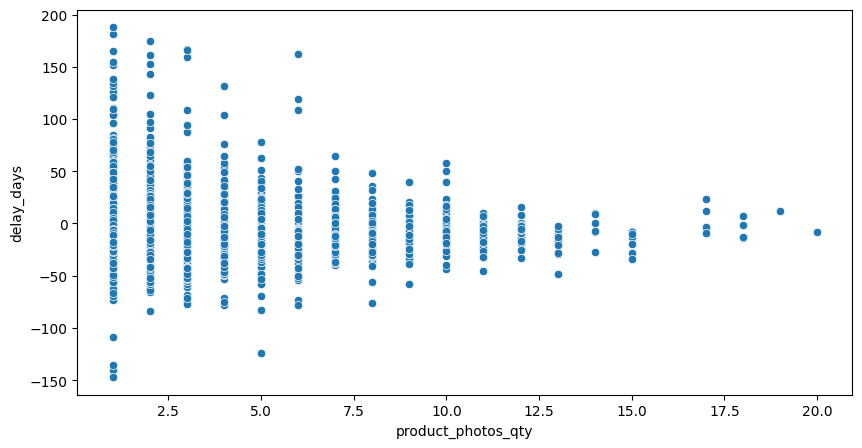

In [54]:
quick_viz(df.product_photos_qty)

In [55]:
df["product_photos_qty"] = df["product_photos_qty"].astype(int) # to make it more clean

**product_weight_g**

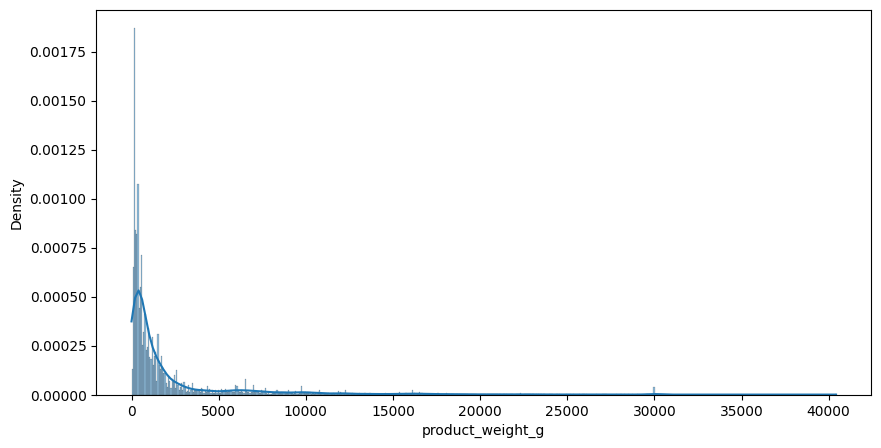

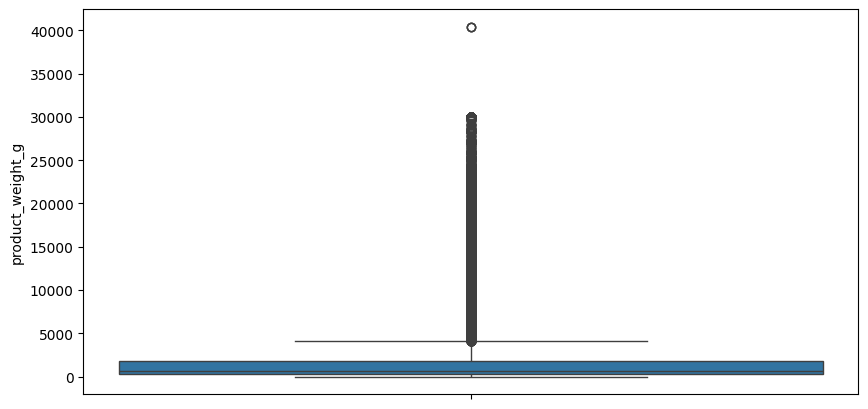

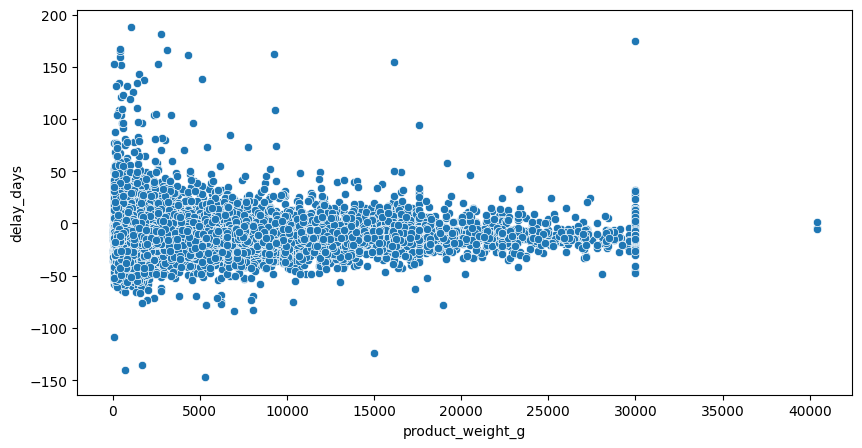

In [56]:
quick_viz(df.product_weight_g)

The relationship remains unclear

**product_length_cm**

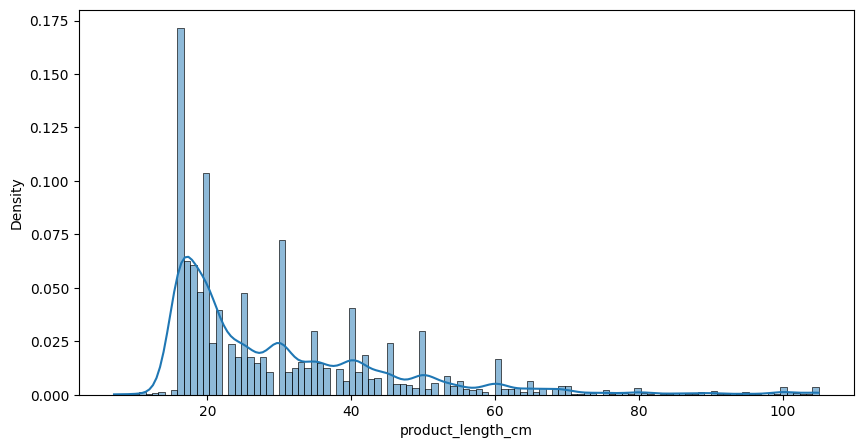

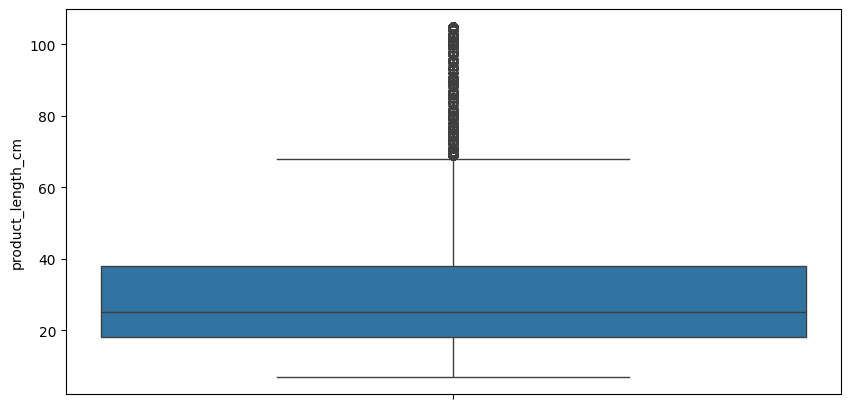

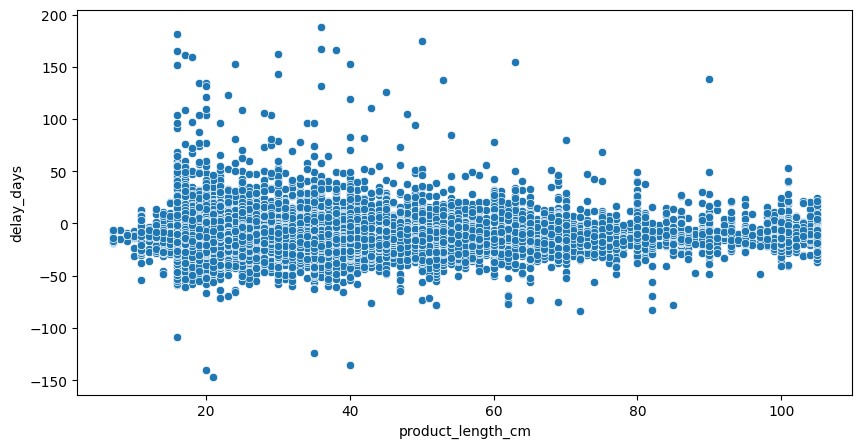

In [57]:
quick_viz(df.product_length_cm)

**product_height_cm**

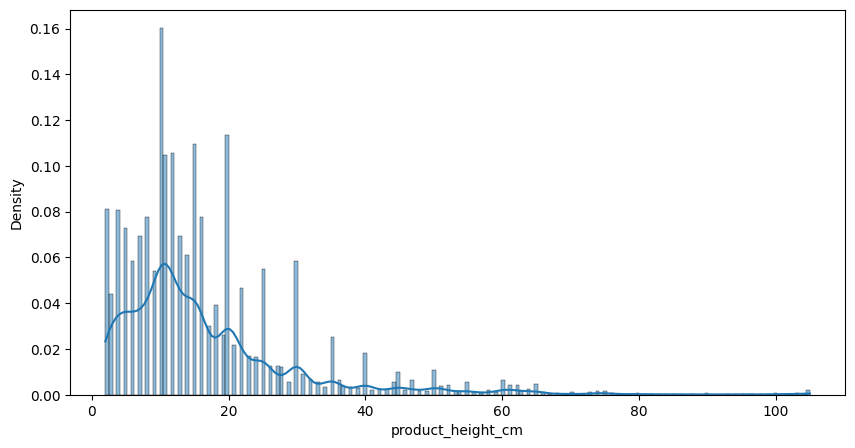

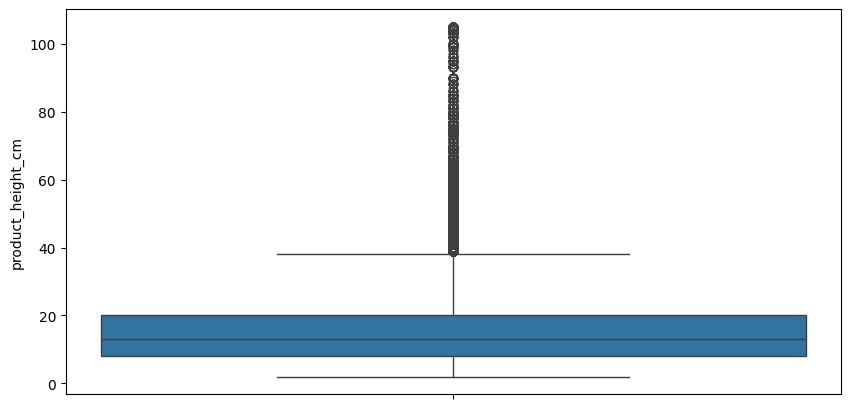

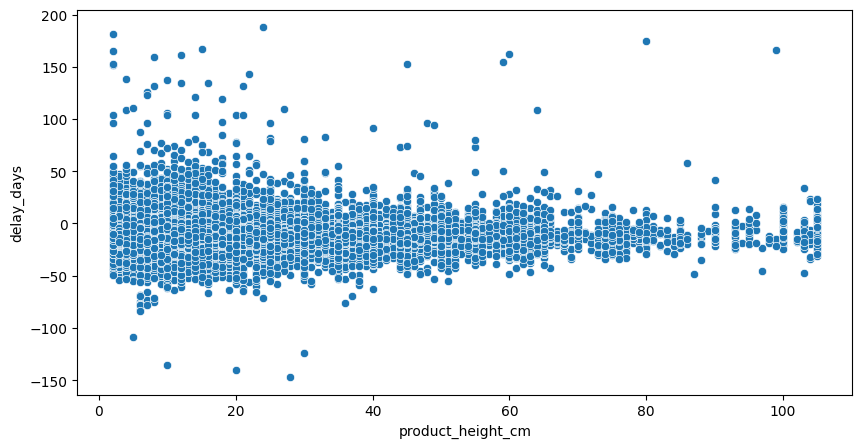

In [58]:
quick_viz(df.product_height_cm)

**product_width_cm**

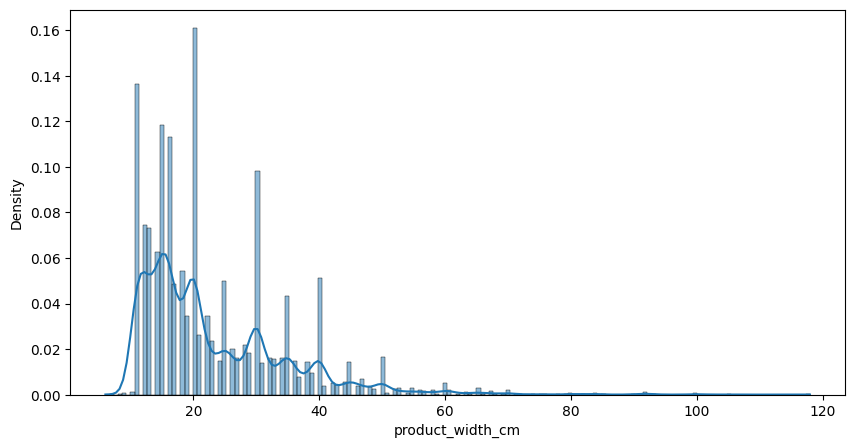

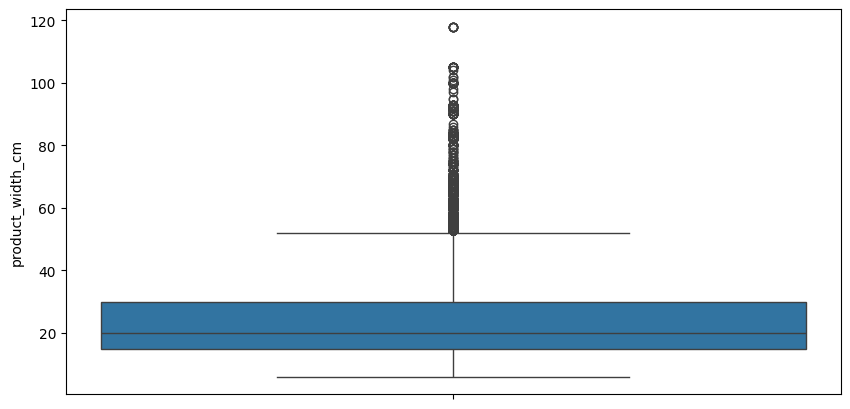

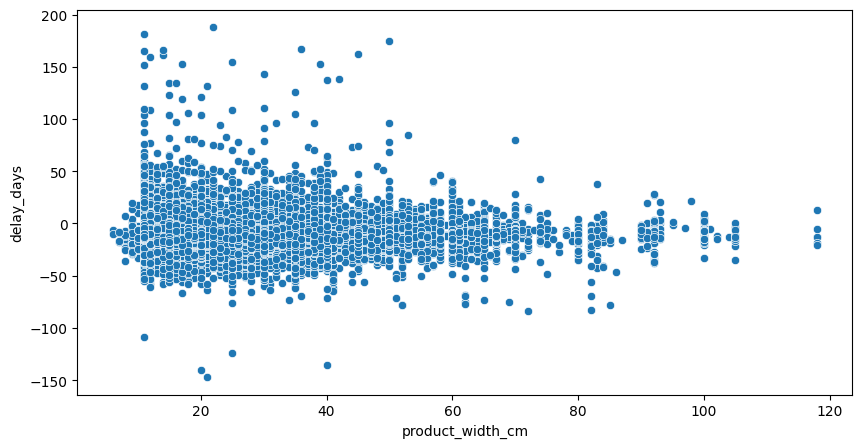

In [59]:
quick_viz(df.product_width_cm)

**product_category_name_english**

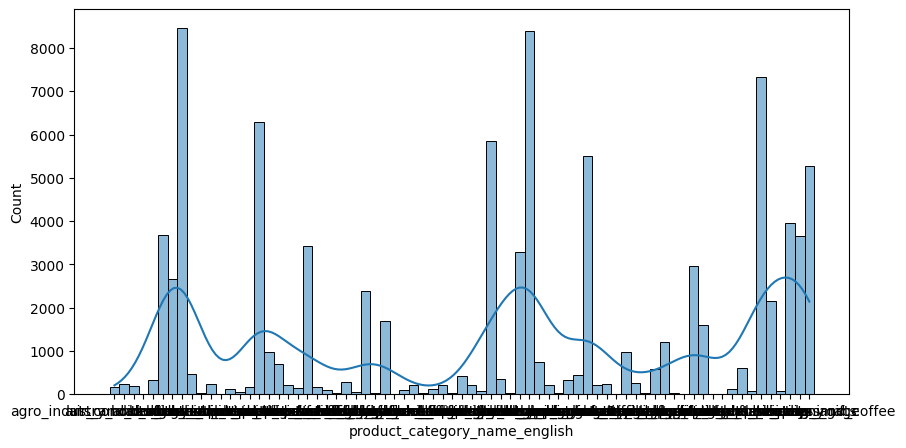

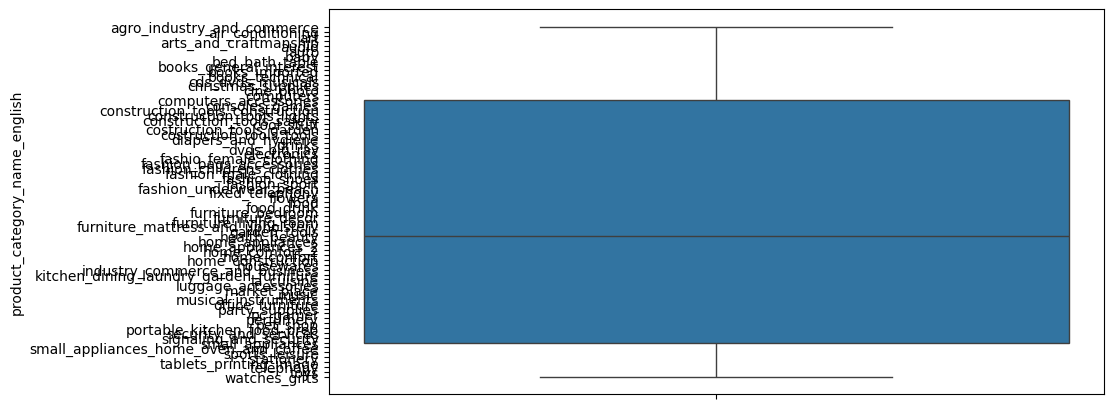

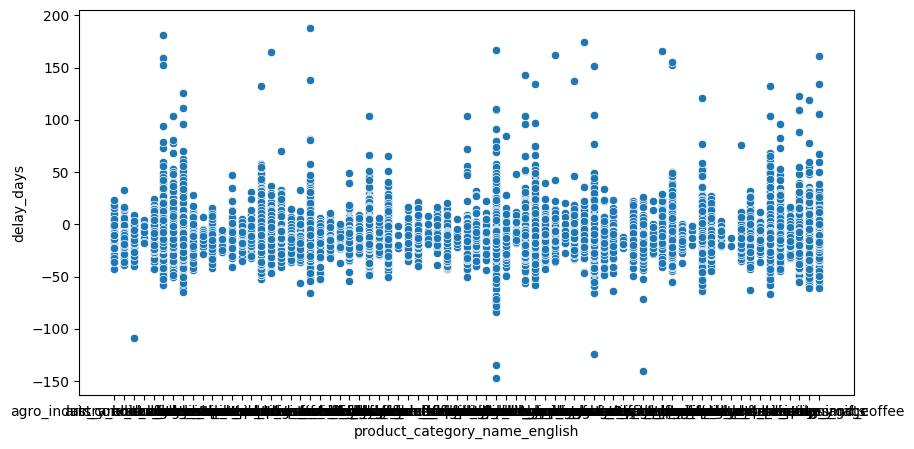

In [60]:
quick_viz_cat(df.product_category_name_english)

**seller_state**

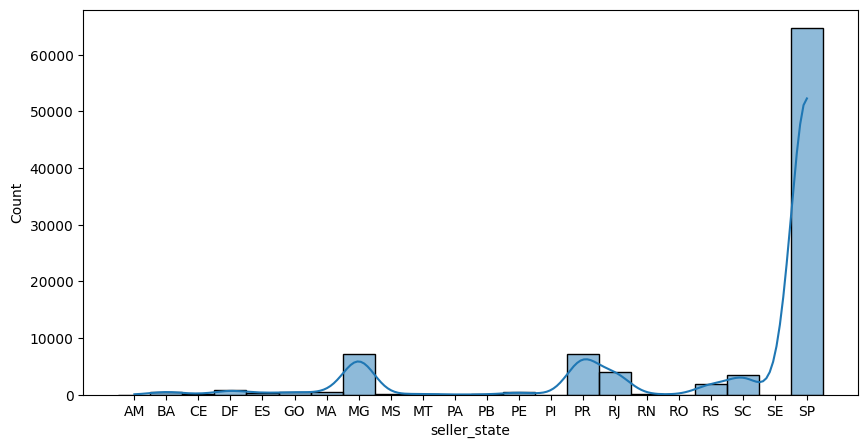

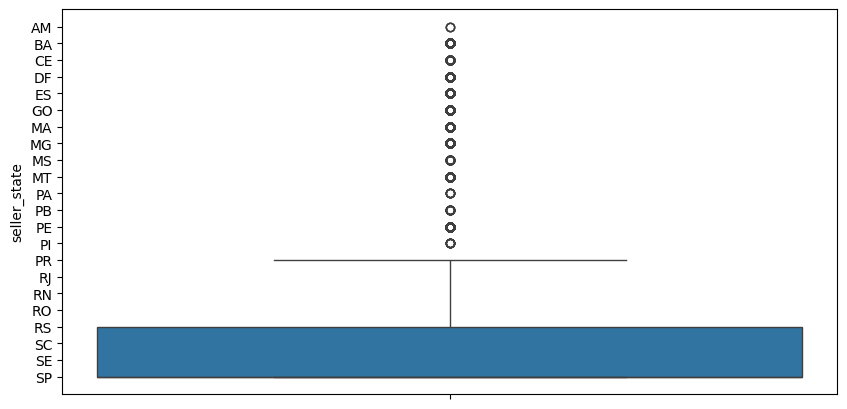

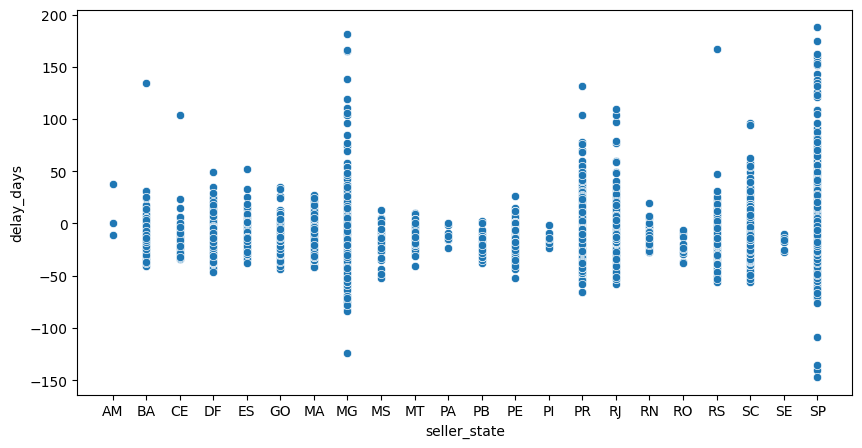

In [61]:
quick_viz_cat(df.seller_state)

**customer_state**

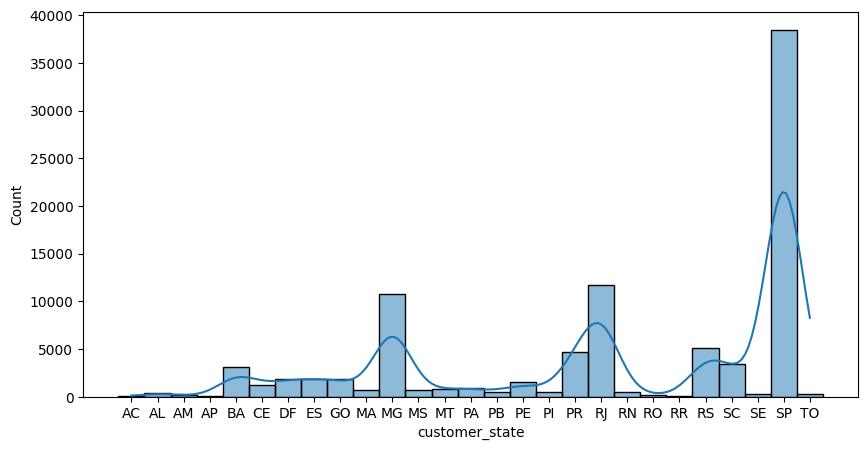

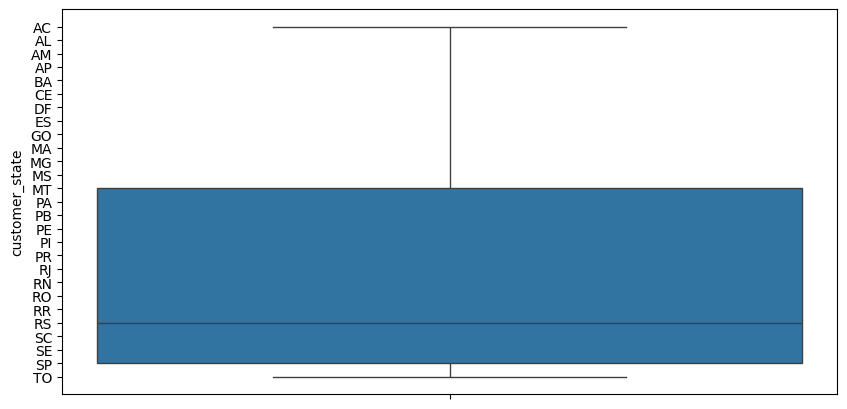

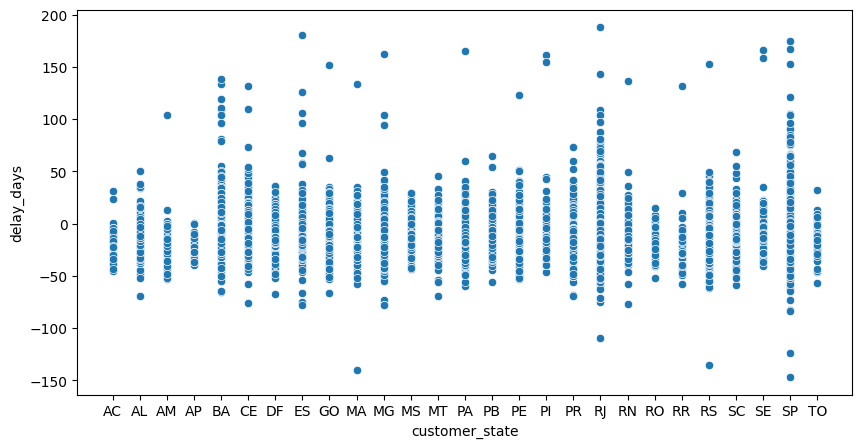

In [62]:
quick_viz_cat(df.customer_state)

We see the difference in behaviour (compared to seller_state) for the state MG, for example

**cust_sell_same_state**

In [63]:
df.cust_sell_same_state.nunique()

2

In [64]:
df["cust_sell_same_state"] = df["cust_sell_same_state"].astype(bool) # to make it more clean

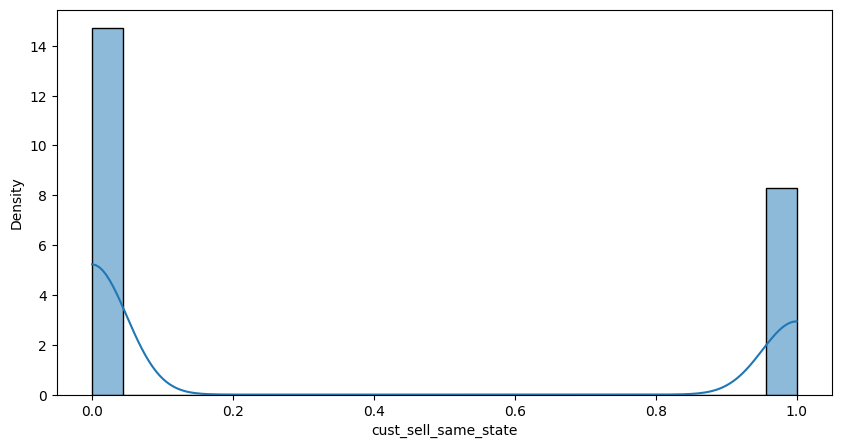

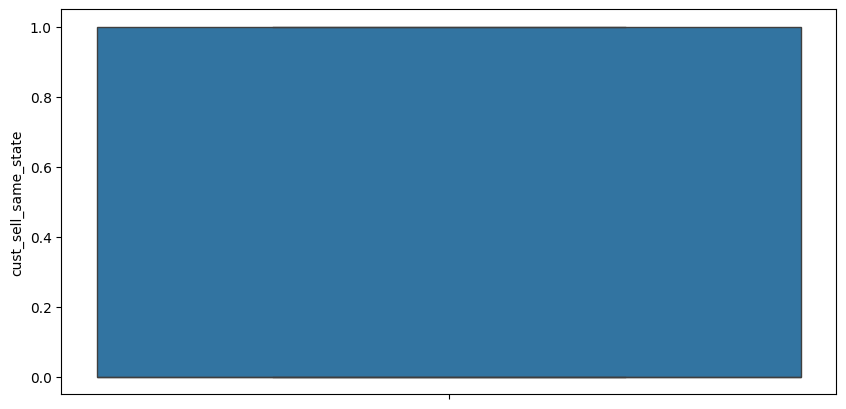

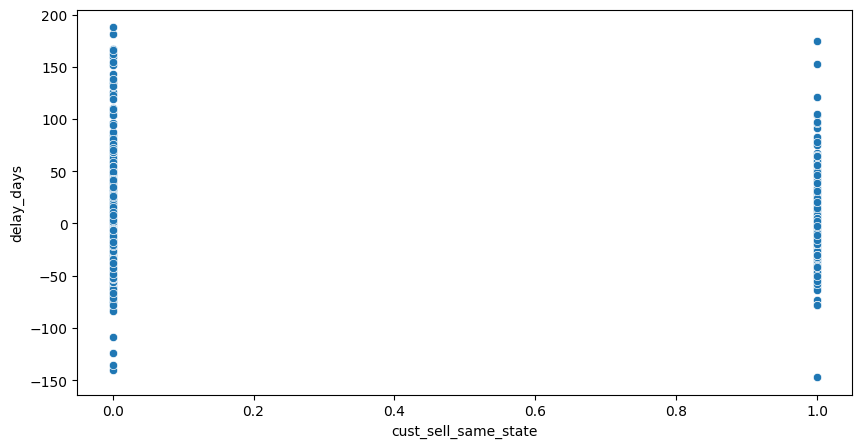

In [65]:
quick_viz(df.cust_sell_same_state)

In [66]:
df.cust_sell_same_state.value_counts()

cust_sell_same_state
False    58543
True     32932
Name: count, dtype: int64

> We see that we get less extreme delays (positive or negative) if the customer and seller are from the same state. Although, we would probably expect to see fewer delays in general when customer and seller are int the same state

**customer_lat, customer_lng, seller_lat, seller_lng**

> We have 4 similar variables next so let's plot them together

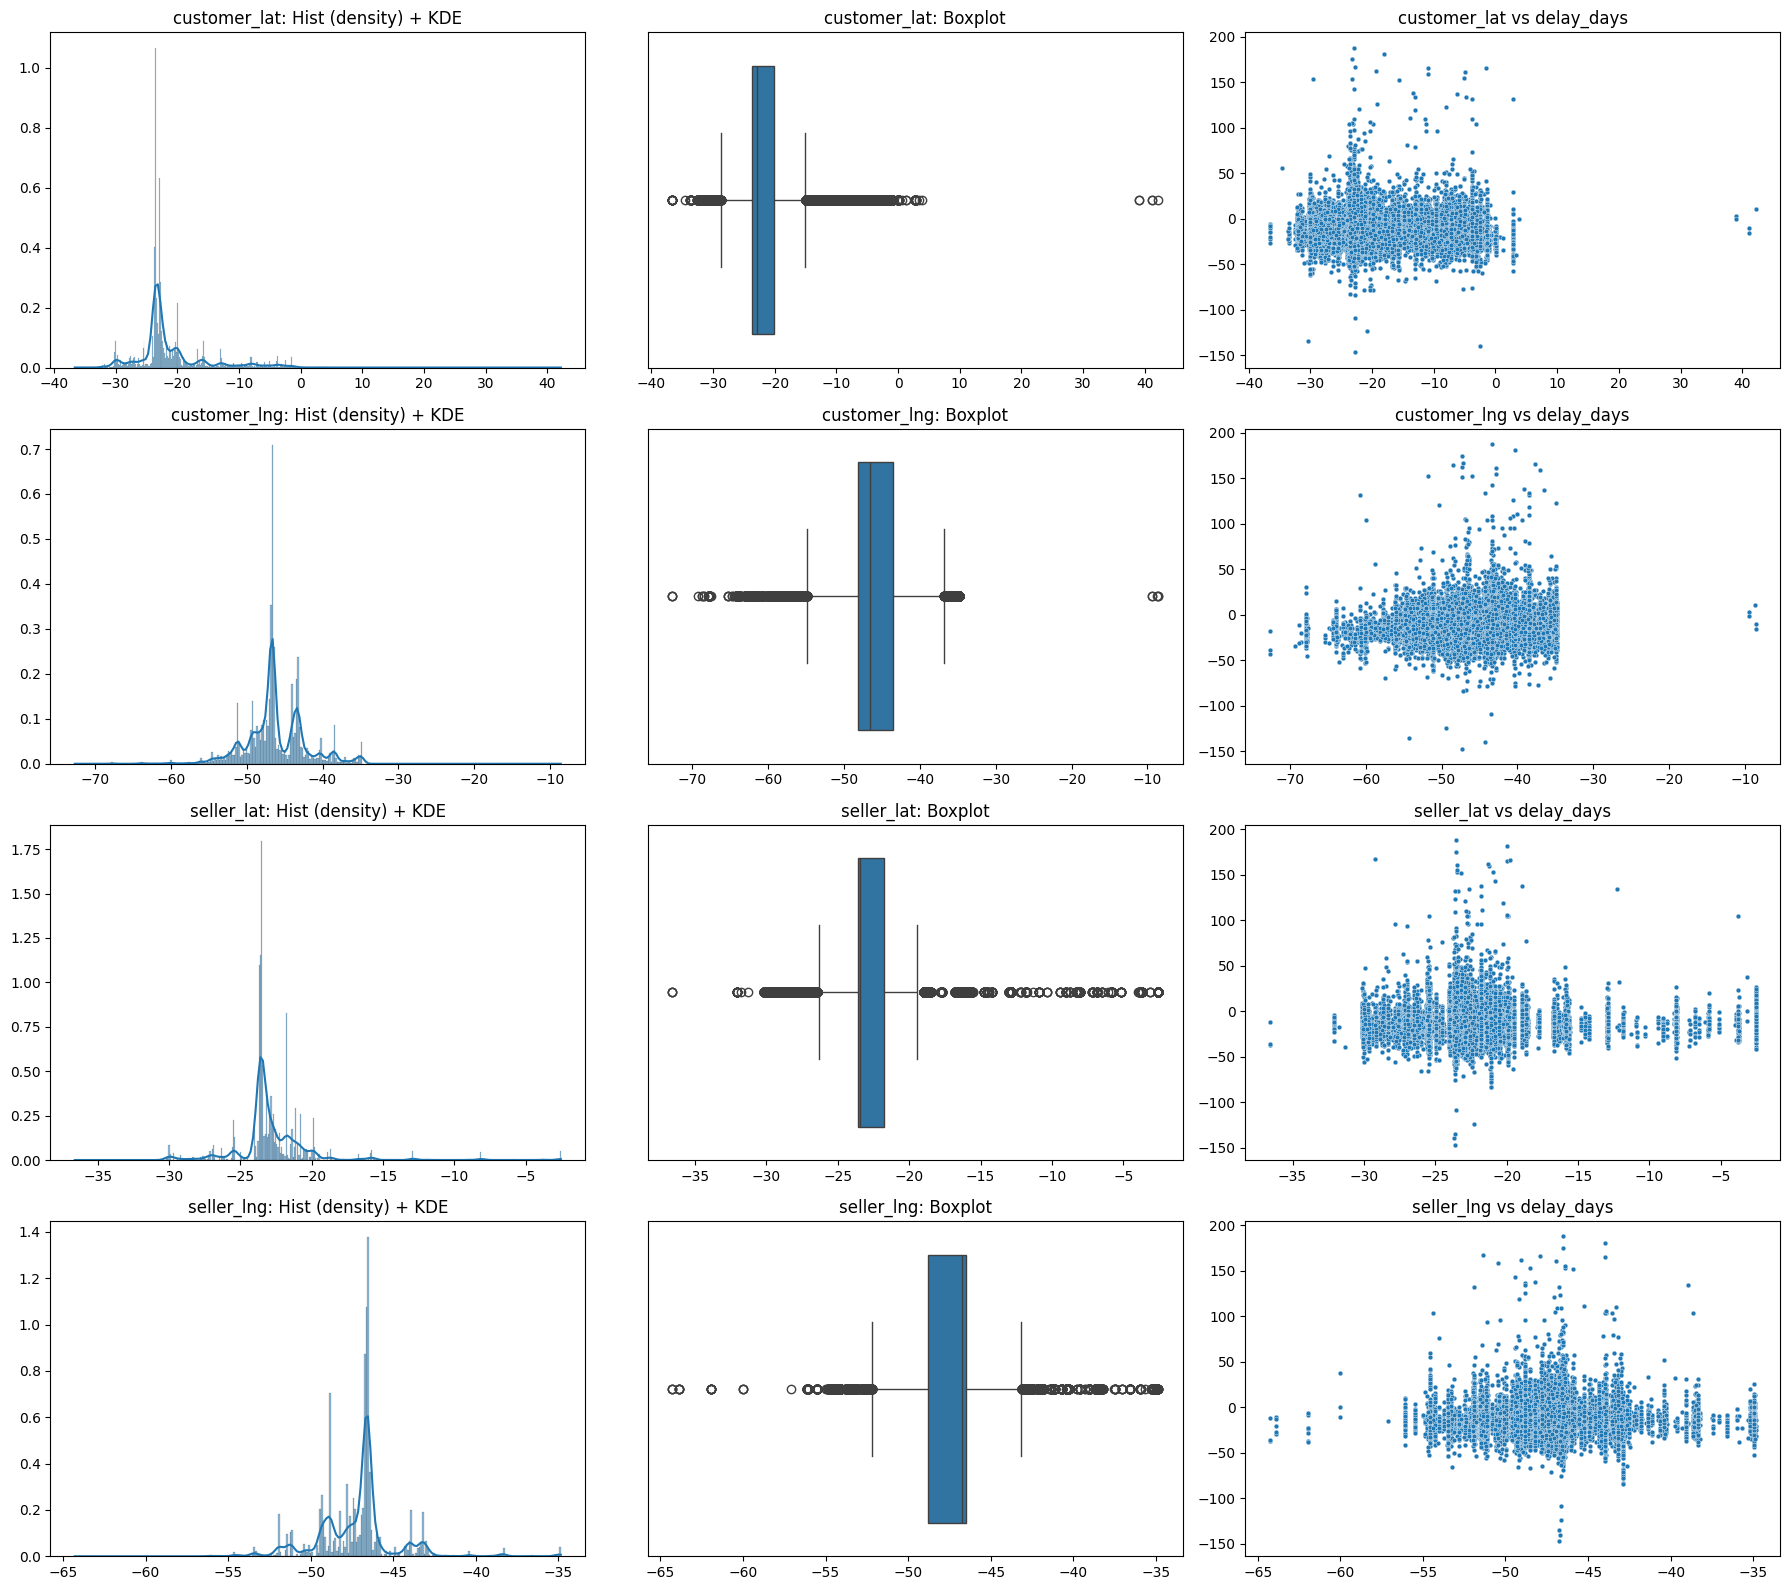

In [67]:
quick_viz_4(df, ["customer_lat", "customer_lng", "seller_lat", "seller_lng"])

In general, we see quite different behaviour between the variables. Customer lat and lng seem to have some outliers. Empirical distributions have long tails but some are multimodal.

**cust_sell_distance**

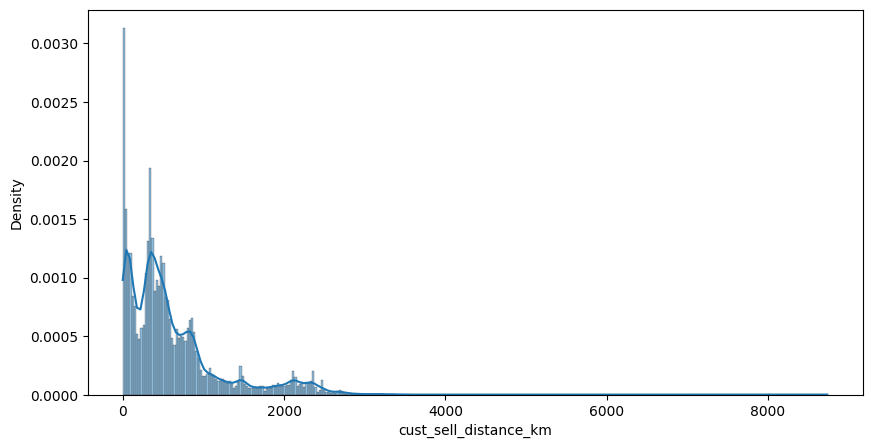

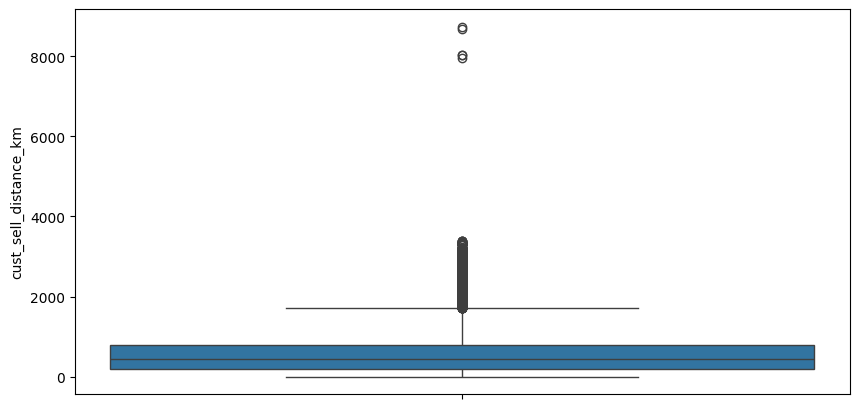

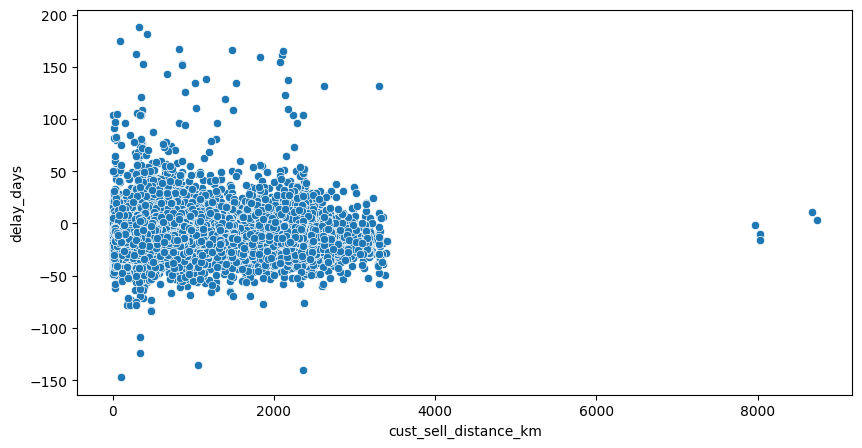

In [68]:
quick_viz(df.cust_sell_distance_km)

We don't seem to get any clear relationships between our features and our target

**order_purchase_month, order_delivery_month**

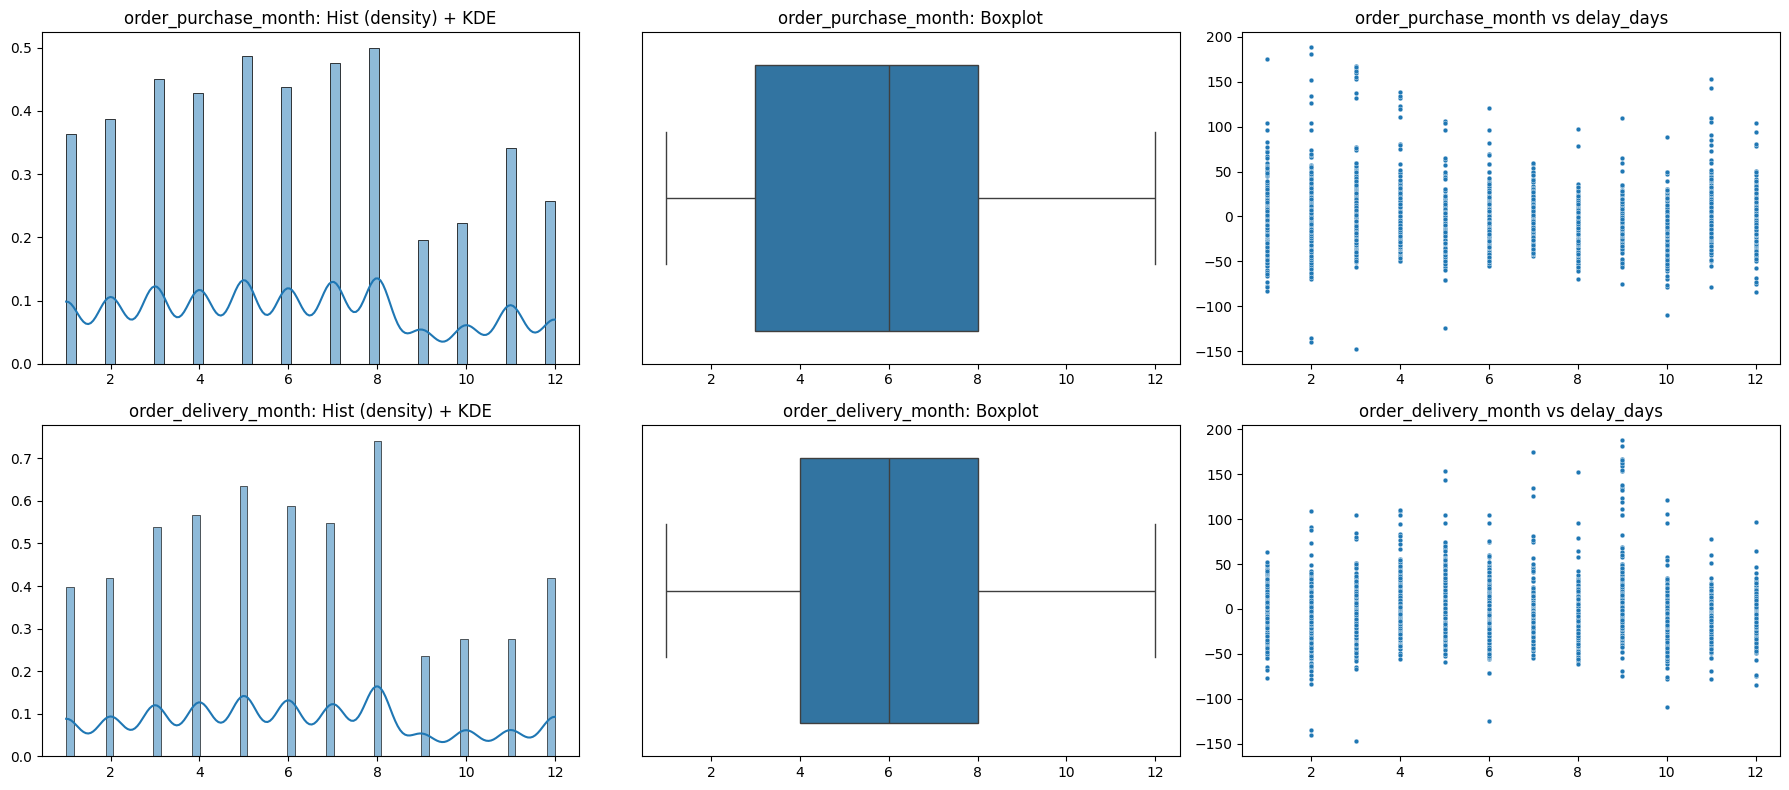

In [69]:
quick_viz_grid(df, ["order_purchase_month", "order_delivery_month"])

**order_year_2016, order_year_2017, order_year_2018, delivery_year_2016, delivery_year_2017, delivery_year_2018**

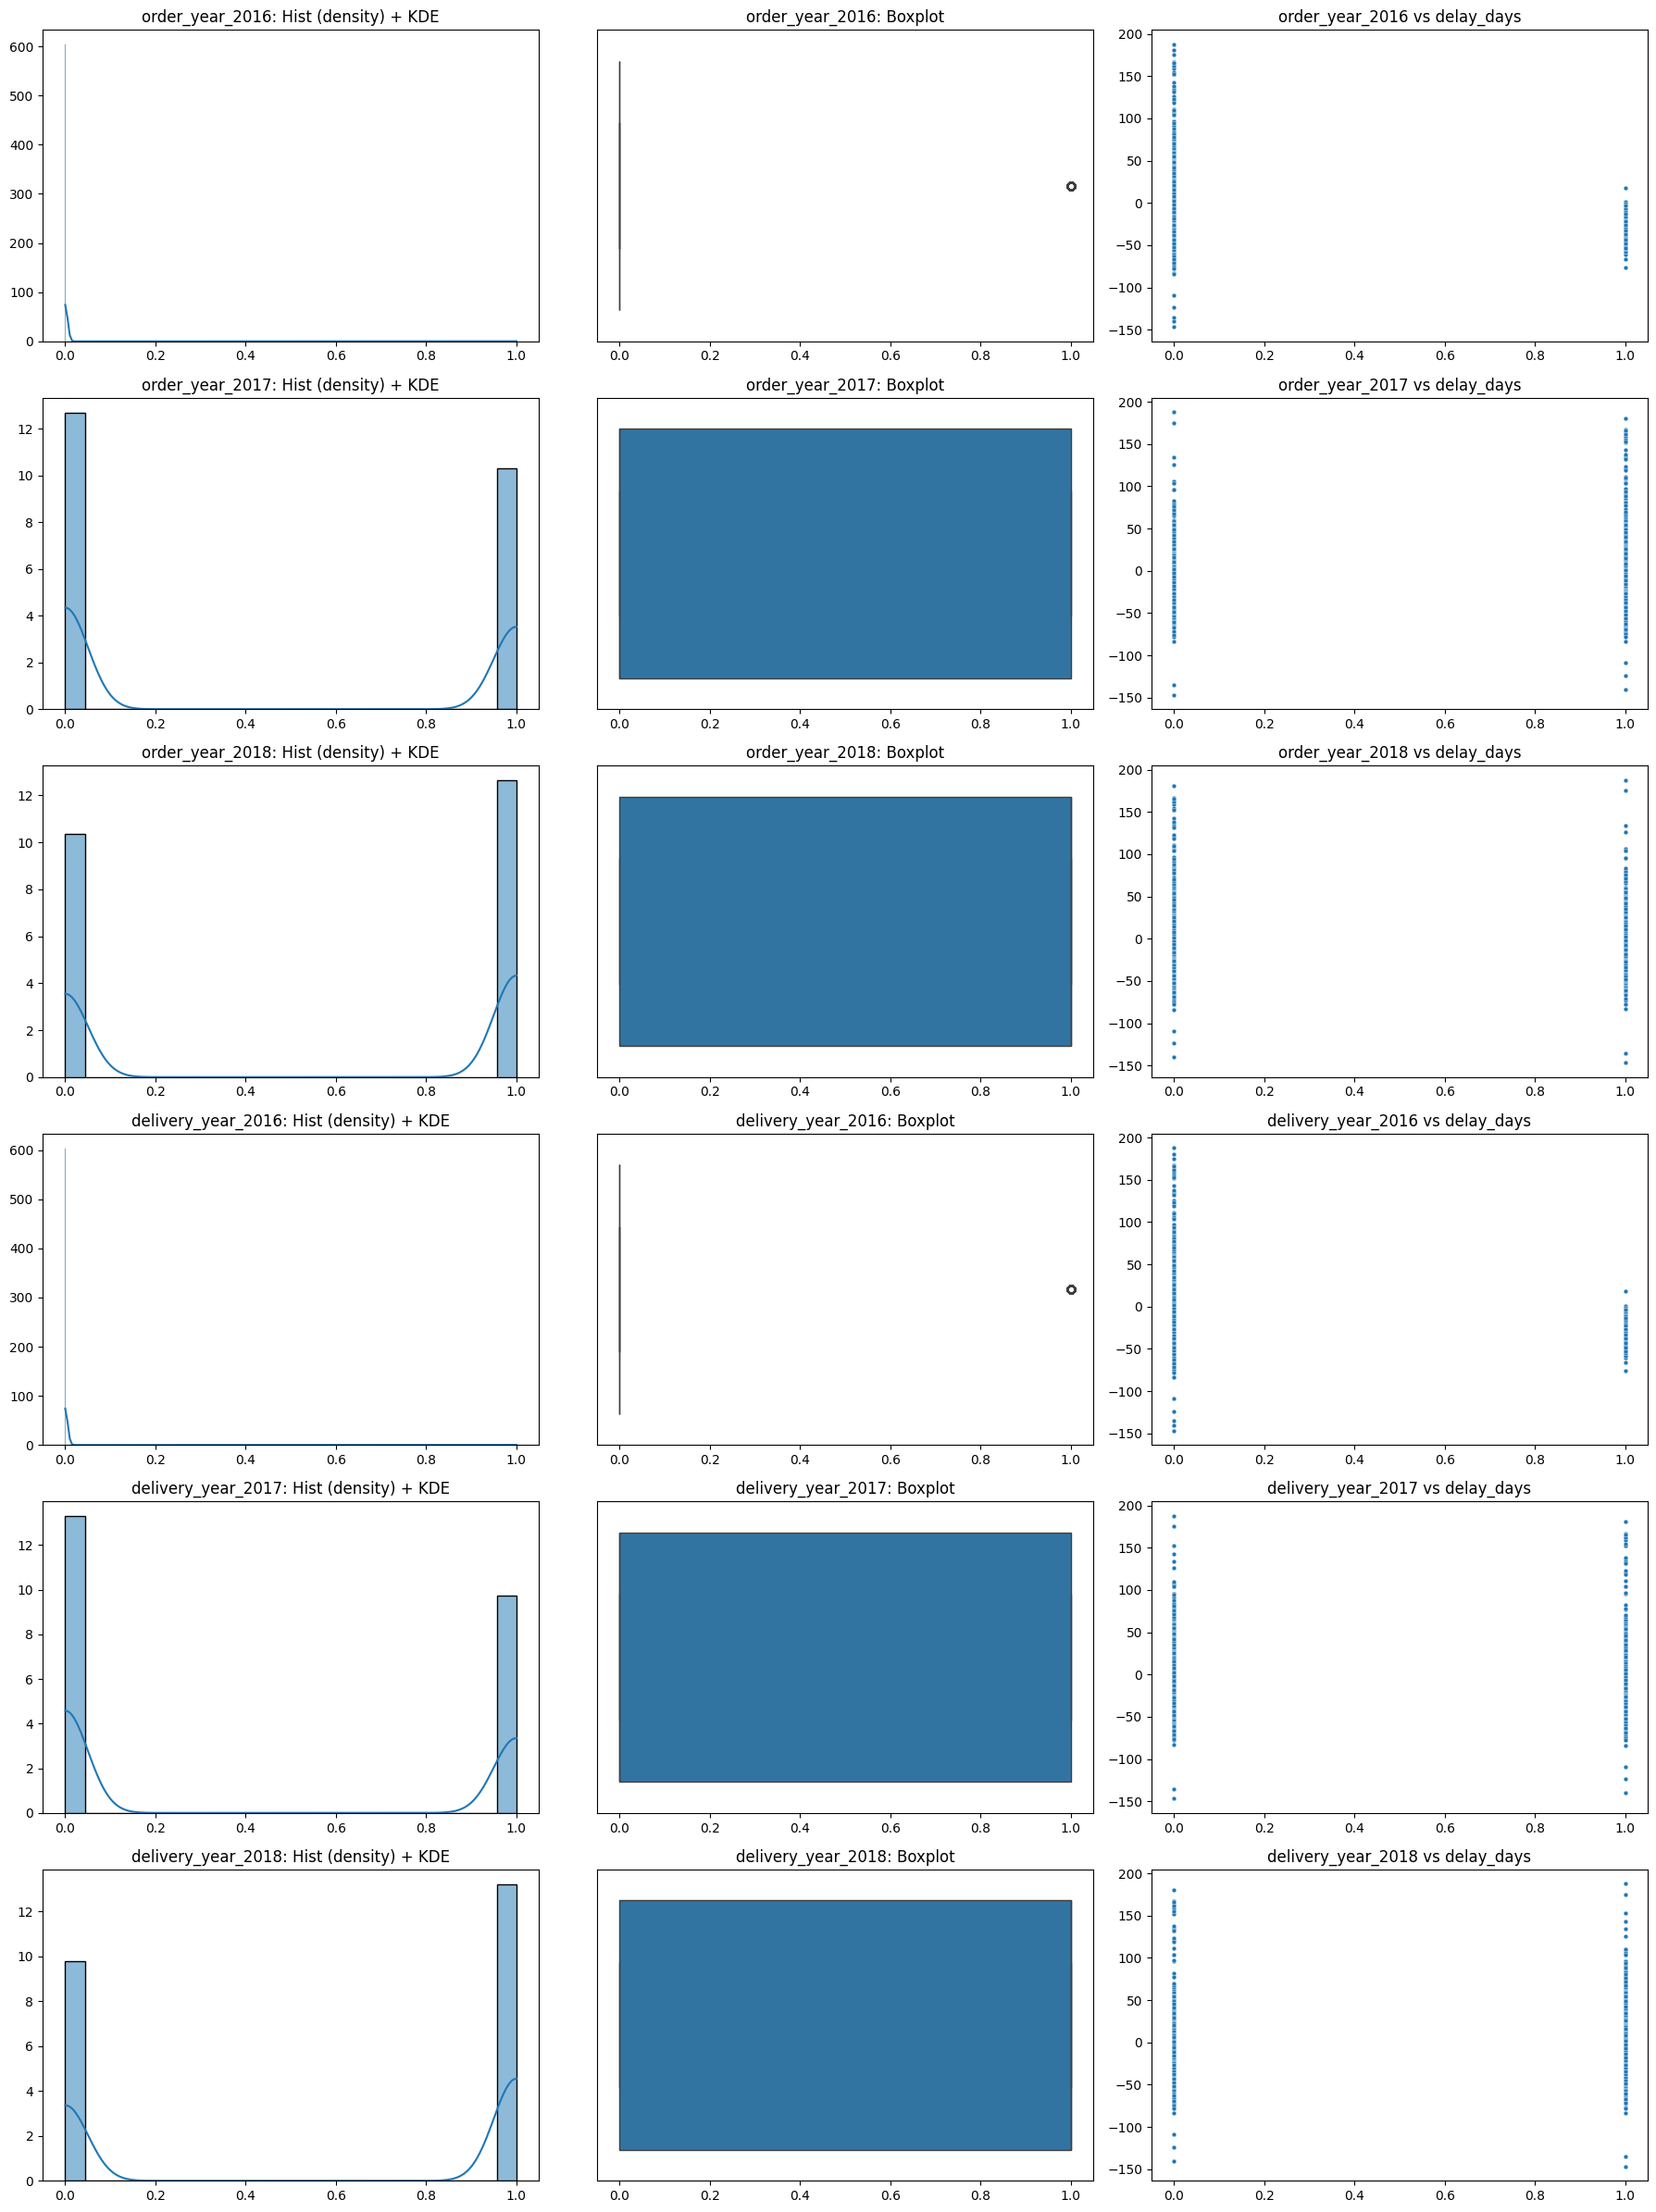

In [70]:
quick_viz_grid(df, ["order_year_2016", "order_year_2017", "order_year_2018",
                     "delivery_year_2016", "delivery_year_2017", "delivery_year_2018"])

# Additional target analysis 

We already analysed *delayed_days* to some extent in Notebook 1. Data introduction and EDA. Here, we may also look at how the distribution of our target changes based on month and year

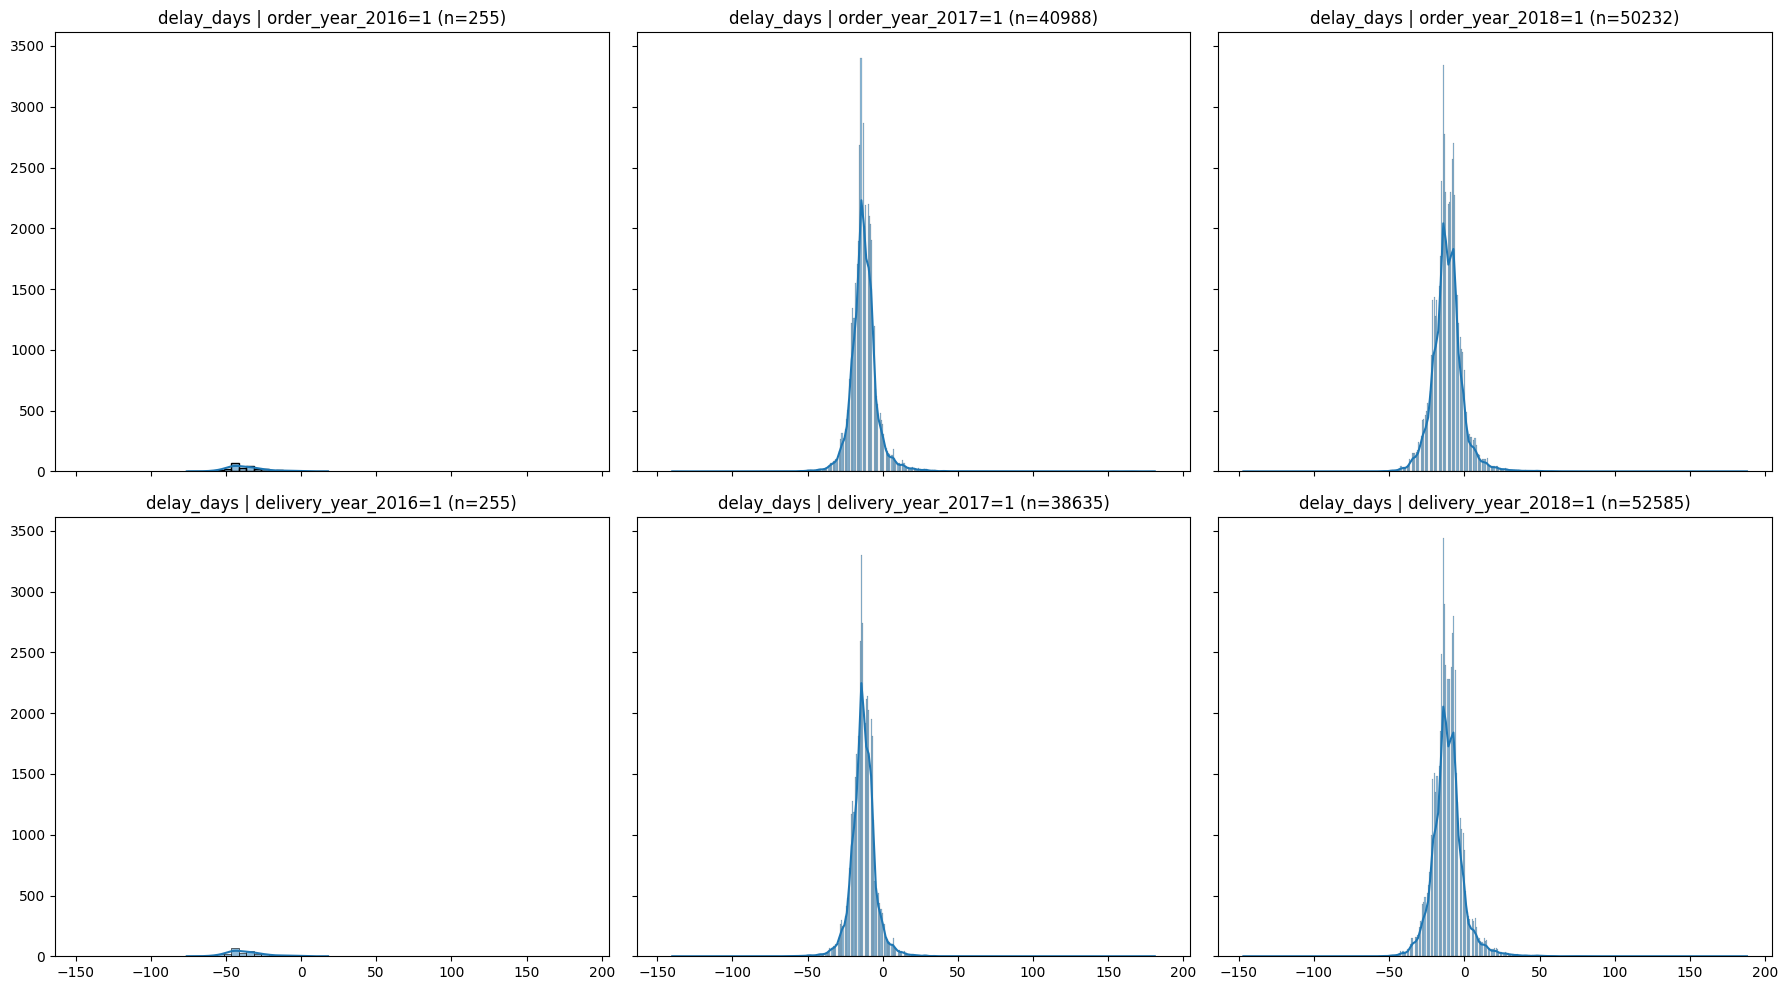

In [71]:
year_cols = [
    "order_year_2016", "order_year_2017", "order_year_2018",
    "delivery_year_2016", "delivery_year_2017", "delivery_year_2018"
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.ravel()

for ax, col in zip(axes, year_cols):
    mask = df[col] == 1
    x = df.loc[mask, "delay_days"].dropna()

    sns.histplot(x=x, ax=ax, kde=True) 
    ax.set_title(f"delay_days | {col}=1 (n={len(x)})")
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

> Interesting - we have almost no orders from 2016 but the distribution doesn't change much between 2017 and 2018

Let's look at all the months now

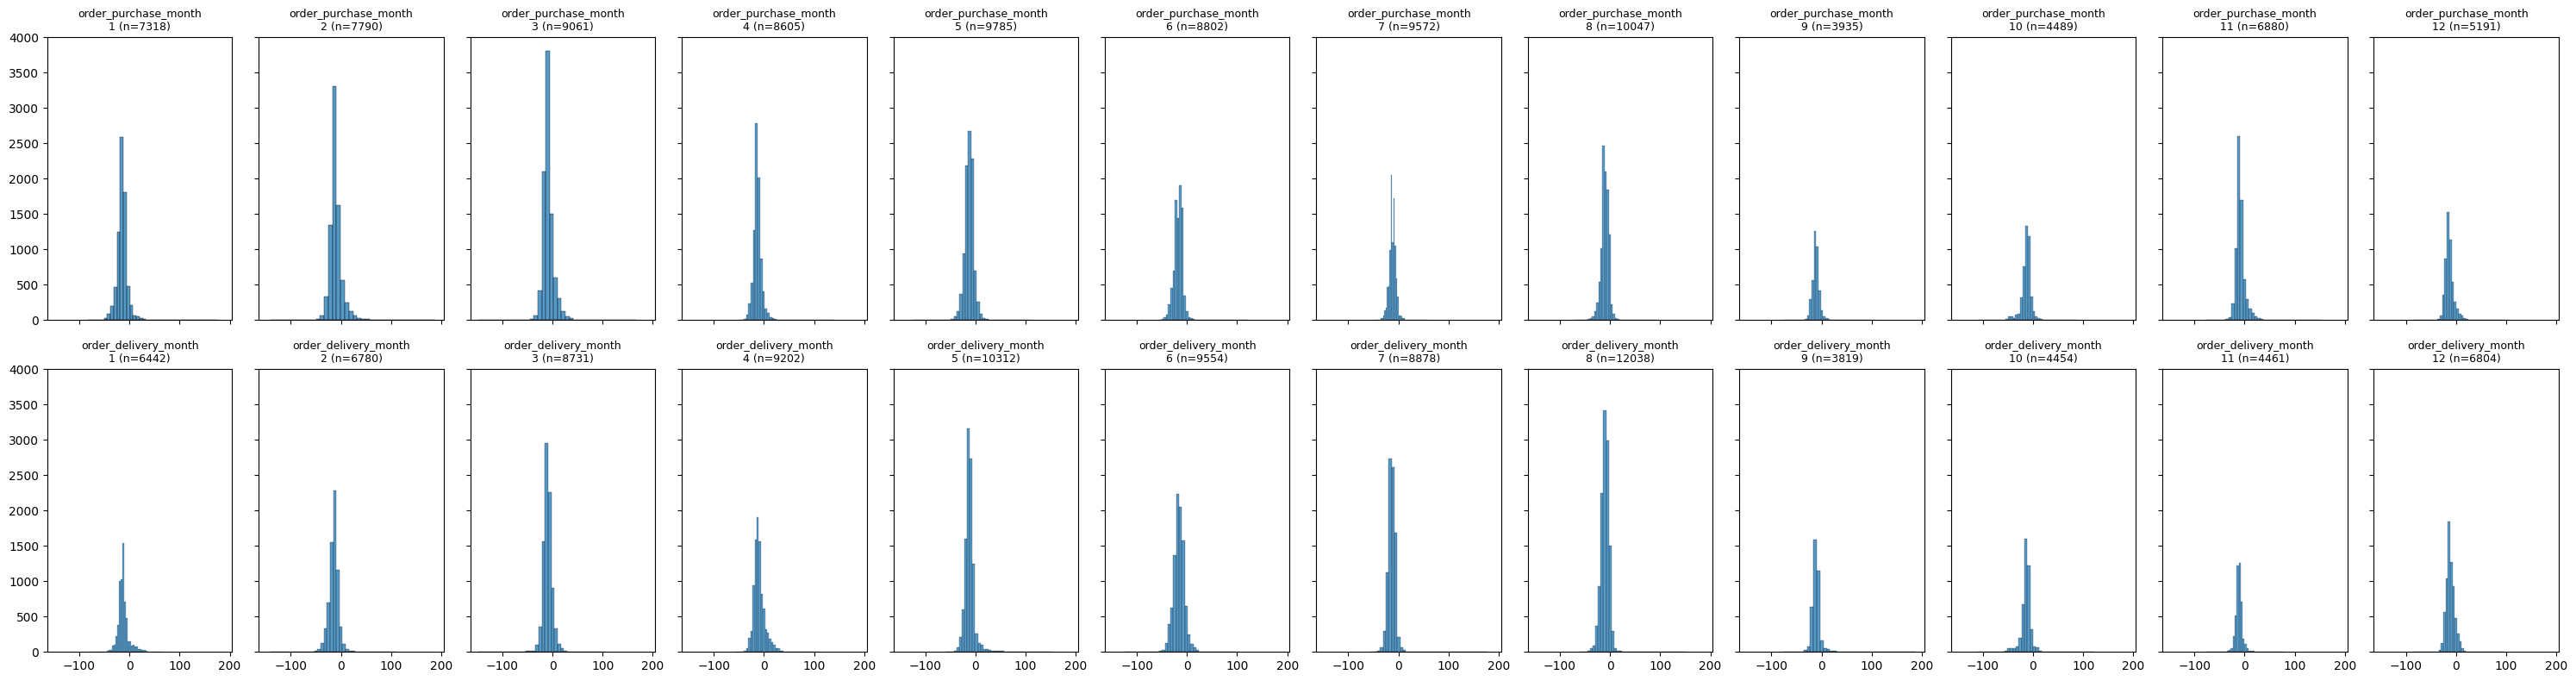

In [72]:
def month_delay_hist_grid(df, month_cols=("order_purchase_month", "order_delivery_month"),
                          delay_col="delay_days", bins=40):
    # collect month levels in a consistent order (works for ints 1..12 or month names)
    month_levels = {}
    for col in month_cols:
        s = df[col].dropna()
        # If it's categorical, keep its category order; otherwise sort unique values
        if str(s.dtype) == "category":
            levels = list(s.cat.categories)
        else:
            levels = sorted(s.unique())
        month_levels[col] = levels

    # 2 rows (one per column), 12 columns (months)
    fig, axes = plt.subplots(nrows=len(month_cols), ncols=12, figsize=(30, 8),
                             sharex=True, sharey=True)

    # If only one row, keep axes 2D
    if len(month_cols) == 1:
        axes = axes.reshape(1, 12)

    for r, col in enumerate(month_cols):
        levels = month_levels[col]

        # If somehow not 12, we still plot what exists and hide the rest
        for c in range(12):
            ax = axes[r, c]
            if c < len(levels):
                m = levels[c]
                x = df.loc[df[col] == m, delay_col].dropna()

                sns.histplot(x=x, bins=bins, ax=ax, kde=False)
                ax.set_title(f"{col}\n{m} (n={len(x)})", fontsize=9)
            else:
                ax.axis("off")

            ax.set_xlabel("")
            ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


month_delay_hist_grid(df, month_cols=("order_purchase_month", "order_delivery_month"))

> After expanding the image we see that the distributions are quite similar - skewed and centred around zero

# Feature ranking methods

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  float64 
 1   order_item_id                  91475 non-null  int64   
 2   total_price                    91475 non-null  float64 
 3   total_freight                  91475 non-null  float64 
 4   order_value_check              91475 non-null  float64 
 5   is_payment_sequential_1        91475 non-null  bool    
 6   payment_type_boleto            91475 non-null  bool    
 7   payment_type_credit_card       91475 non-null  bool    
 8   payment_type_debit_card        91475 non-null  bool    
 9   payment_type_voucher           91475 non-null  bool    
 10  installments_boleto            91475 non-null  int64   
 11  installments_credit_card       91475 non-null  int64   
 12  installments_debit_card        9

> Our features do not show a clear relationship with our target. This may be problematic. It may also be the case the plots we've used won't immediately tell us everything.

> Let's try out some feature ranking methods so that we don't just blindly use 30+ columns in our models. This should help us in proritizing certain features

## Correlations

We can look at a correlation heatmap for continuous variables. We are using kendall correlation as the relationships are unlikely to be linear

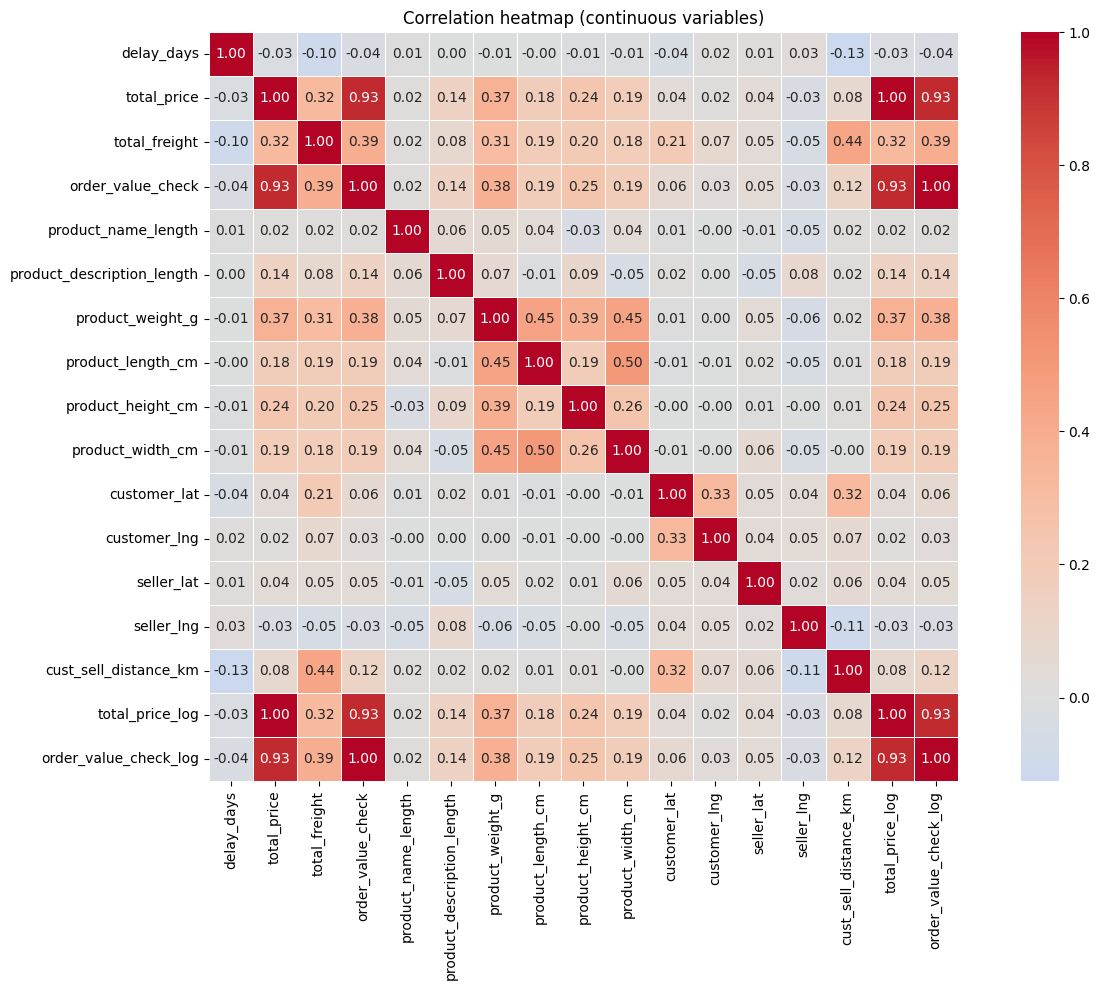

In [74]:
cols = [
    "delay_days", "total_price", "total_freight", "order_value_check",
    "product_name_length", "product_description_length", "product_weight_g",
    "product_length_cm", "product_height_cm", "product_width_cm",
    "customer_lat", "customer_lng", "seller_lat", "seller_lng",
    "cust_sell_distance_km", "total_price_log", "order_value_check_log"
]

corr = df[cols].corr(method="kendall") 

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True)
plt.title("Correlation heatmap (continuous variables)")
plt.tight_layout()
plt.show()


Our continuous features seem to be very poorly correlated with our target. Let's try Spearman correlation coefficient just to have a bigger picture

The very high correlations are due to variable transformation

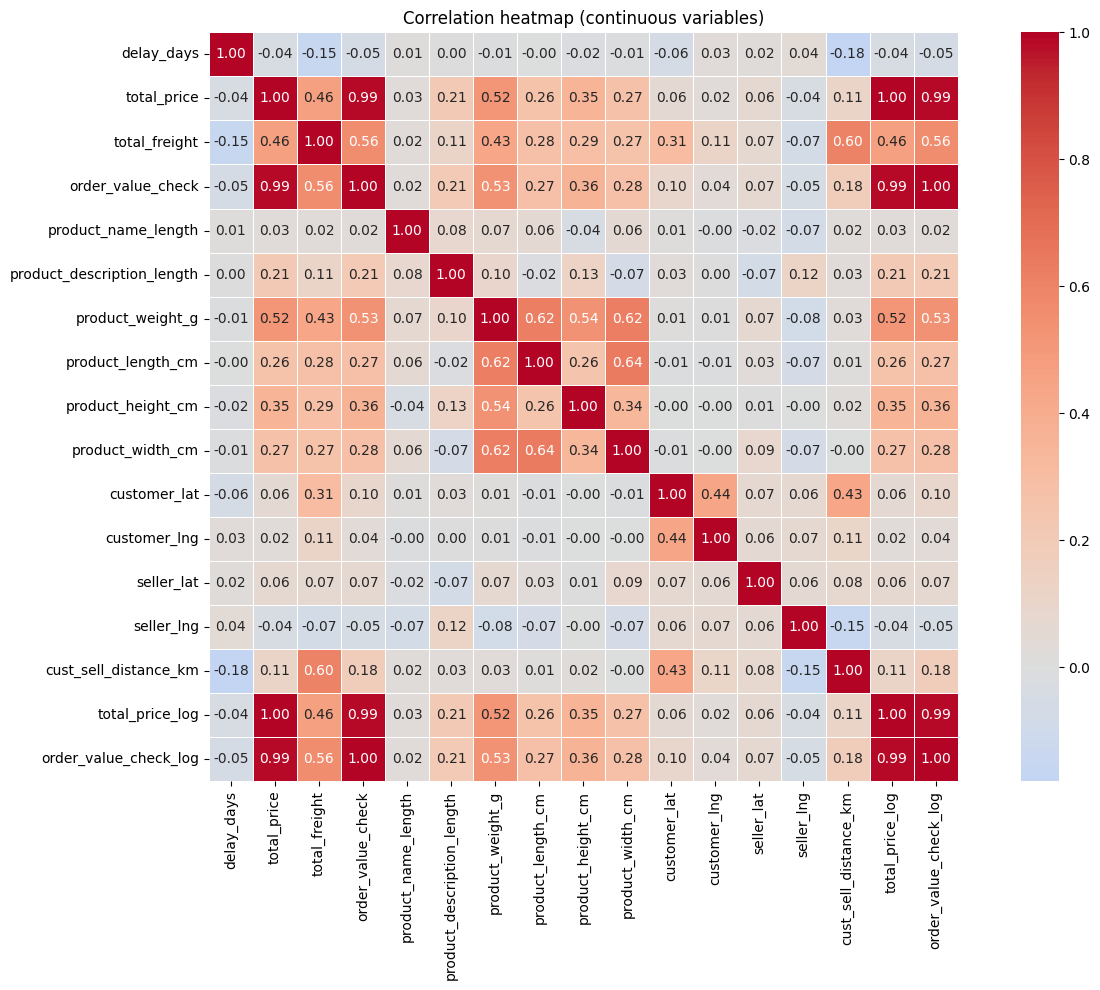

In [75]:
cols = [
    "delay_days", "total_price", "total_freight", "order_value_check",
    "product_name_length", "product_description_length", "product_weight_g",
    "product_length_cm", "product_height_cm", "product_width_cm",
    "customer_lat", "customer_lng", "seller_lat", "seller_lng",
    "cust_sell_distance_km", "total_price_log", "order_value_check_log"
]

corr = df[cols].corr(method="spearman")  

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True)
plt.title("Correlation heatmap (continuous variables)")
plt.tight_layout()
plt.show()


> We obtain similar results

> What's interesting is that the product dimensions do not seem to be correlated very much with delay_days. It could be argued that smaller products would experience different dealys to big or heavy products

> We can also see that the transformations do not affect the correlation much

> The sign on the correlation between cust_sell_distance_km and delay_days is also weird. It would indicate that the greater the distance between customer and seller the shorter the delay.

## Feature selection

We will utilise some methods of feature selection from [ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates GiHub repository](https://github.com/michaelwozniak/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  float64 
 1   order_item_id                  91475 non-null  int64   
 2   total_price                    91475 non-null  float64 
 3   total_freight                  91475 non-null  float64 
 4   order_value_check              91475 non-null  float64 
 5   is_payment_sequential_1        91475 non-null  bool    
 6   payment_type_boleto            91475 non-null  bool    
 7   payment_type_credit_card       91475 non-null  bool    
 8   payment_type_debit_card        91475 non-null  bool    
 9   payment_type_voucher           91475 non-null  bool    
 10  installments_boleto            91475 non-null  int64   
 11  installments_credit_card       91475 non-null  int64   
 12  installments_debit_card        9

For easier processing let's change our category variables to cat_code

In [77]:
cat_cols = ["product_category_name_english", "seller_state", "customer_state"]

for c in cat_cols:
    df[c] = df[c].cat.codes  # converts category -> int codes (NaN becomes -1)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     91475 non-null  float64
 1   order_item_id                  91475 non-null  int64  
 2   total_price                    91475 non-null  float64
 3   total_freight                  91475 non-null  float64
 4   order_value_check              91475 non-null  float64
 5   is_payment_sequential_1        91475 non-null  bool   
 6   payment_type_boleto            91475 non-null  bool   
 7   payment_type_credit_card       91475 non-null  bool   
 8   payment_type_debit_card        91475 non-null  bool   
 9   payment_type_voucher           91475 non-null  bool   
 10  installments_boleto            91475 non-null  int64  
 11  installments_credit_card       91475 non-null  int64  
 12  installments_debit_card        91475 non-null 

delay_days  order_item_id  total_price  total_freight  order_value_check  \
0        -8.0              1        29.99           8.72              38.71   
1        -6.0              1       118.70          22.76             141.46   
2       -18.0              1       159.90          19.22             179.12   
3       -13.0              1        45.00          27.20              72.20   
4       -10.0              1        19.90           8.72              28.62   

   is_payment_sequential_1  payment_type_boleto  payment_type_credit_card  \
0                     True                False                      True   
1                     True                 True                     False   
2                     True                False                      True   
3                     True                False                      True   
4                     True                False                      True   

   payment_type_debit_card  payment_type_voucher  ...  order_purchase_month  \
0                    False                 False  ...                    10   
1                    False                 False  ...                     7   
2                    False                 False  ...                     8   
3                    False                 False  ...                    11   
4                    False                 False  ...                     2   

   order_delivery_month  order_year_2016  order_year_2017  order_year_2018  \
0                    10                0                1                0   
1                     8                0                0                1   
2                     8                0                0                1   
3                    12                0                1                0   
4                     2                0                0                1   

   delivery_year_2016  delivery_year_2017  delivery_year_2018  \
0                   0                   1                   0   
1                   0                   0                   1   
2                   0                   0                   1   
3                   0                   1                   0   
4                   0                   0                   1   

   total_price_log  order_value_check_log  
0         3.400864               3.656098  
1         4.776599               4.952017  
2         5.074549               5.188056  
3         3.806662               4.279440  
4         2.990720               3.354106  

[5 rows x 40 columns]

**Preparation** 

Feature columns

In [78]:
exclude = ["delay_days", "total_price_log", "order_value_check_log"]
x_col = [c for c in df.columns if c not in exclude]

Target column

In [79]:
y_col = "delay_days"

General ranking to collect the ranking scores

In [80]:
general_ranking = pd.DataFrame(index=x_col)

**Mutual information**

From [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html):

 Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. **It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.** The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances. Both methods are based on the idea originally proposed in.

In [81]:
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_regression(df[[i]].values, df[y_col].values)[0]})

miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["mi_score"])

miDF.sort_values(by="mi_score", ascending=False).head(10)

mi_score
total_freight          0.075312
order_purchase_month   0.063411
order_delivery_month   0.060478
seller_lat             0.058045
seller_lng             0.057292
cust_sell_distance_km  0.052626
customer_lat           0.047634
customer_lng           0.045388
order_value_check      0.044252
customer_state         0.042530

Total_freight seems to be the best here

In [82]:
general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)

**Boruta rank**

Good feature selector for tree-based methods (may take several minutes)

In [83]:
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

feat_selector = bp(rf, n_estimators=100, verbose=0, max_iter=50)

feat_selector.fit(df.loc[:, x_col].values, df.loc[:, y_col].values.ravel())

KeyboardInterrupt: 

In [ ]:
feat_selector.ranking_

array([19,  4,  2, 13, 22, 16, 18, 22, 22, 16, 14, 22, 20,  3,  7, 15,  5,
       11, 10,  8,  8,  1, 12,  1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

In [ ]:
boruta_DF = pd.DataFrame(index=x_col)

boruta_DF["boruta_rank"] = feat_selector.ranking_

general_ranking = pd.merge(
    general_ranking, boruta_DF, left_index=True, right_index=True, how="left"
)

## Summary

In [ ]:
pd.set_option("display.max_rows", 50)

general_ranking.sort_values(["boruta_rank", "mi_score"], ascending=True)

mi_score  boruta_rank
order_year_2016                0.007880            1
order_year_2017                0.009391            1
delivery_year_2016             0.010228            1
delivery_year_2017             0.011517            1
order_year_2018                0.015018            1
delivery_year_2018             0.016375            1
seller_state                   0.019504            1
cust_sell_same_state           0.040185            1
customer_lng                   0.045953            1
customer_lat                   0.046373            1
cust_sell_distance_km          0.052663            1
seller_lng                     0.058529            1
order_purchase_month           0.062428            1
order_delivery_month           0.063832            1
total_freight                  0.074788            2
product_name_length            0.000000            3
total_price                    0.013343            4
product_weight_g               0.009915            5
seller_lat                     0.056735            6
product_description_length     0.022008            7
product_width_cm               0.001112            8
product_category_name_english  0.006217            8
product_height_cm              0.004258           10
product_length_cm              0.010257           11
customer_state                 0.041699           12
order_value_check              0.045390           13
installments_credit_card       0.001037           14
product_photos_qty             0.000000           15
installments_boleto            0.000000           16
payment_type_boleto            0.006024           16
payment_type_credit_card       0.004936           18
order_item_id                  0.000000           19
installments_voucher           0.000000           20
payment_type_debit_card        0.000000           22
payment_type_voucher           0.000000           22
installments_debit_card        0.000000           22
is_payment_sequential_1        0.004304           22

In [ ]:
general_ranking.to_excel("3.feature_ranking/feature_ranking.xlsx")

# Train/test split

We will remove the log transformations

In [84]:
df = df.drop(columns=["total_price_log","order_value_check_log" ])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     91475 non-null  float64
 1   order_item_id                  91475 non-null  int64  
 2   total_price                    91475 non-null  float64
 3   total_freight                  91475 non-null  float64
 4   order_value_check              91475 non-null  float64
 5   is_payment_sequential_1        91475 non-null  bool   
 6   payment_type_boleto            91475 non-null  bool   
 7   payment_type_credit_card       91475 non-null  bool   
 8   payment_type_debit_card        91475 non-null  bool   
 9   payment_type_voucher           91475 non-null  bool   
 10  installments_boleto            91475 non-null  int64  
 11  installments_credit_card       91475 non-null  int64  
 12  installments_debit_card        91475 non-null 

delay_days  order_item_id  total_price  total_freight  order_value_check  \
0        -8.0              1        29.99           8.72              38.71   
1        -6.0              1       118.70          22.76             141.46   
2       -18.0              1       159.90          19.22             179.12   
3       -13.0              1        45.00          27.20              72.20   
4       -10.0              1        19.90           8.72              28.62   

   is_payment_sequential_1  payment_type_boleto  payment_type_credit_card  \
0                     True                False                      True   
1                     True                 True                     False   
2                     True                False                      True   
3                     True                False                      True   
4                     True                False                      True   

   payment_type_debit_card  payment_type_voucher  ...  seller_lng  \
0                    False                 False  ...  -46.452454   
1                    False                 False  ...  -43.984727   
2                    False                 False  ...  -48.232976   
3                    False                 False  ...  -43.923299   
4                    False                 False  ...  -46.260979   

   cust_sell_distance_km  order_purchase_month  order_delivery_month  \
0              18.063837                    10                    10   
1             856.292580                     7                     8   
2             514.130333                     8                     8   
3            1822.800366                    11                    12   
4              30.174037                     2                     2   

   order_year_2016  order_year_2017  order_year_2018  delivery_year_2016  \
0                0                1                0                   0   
1                0                0                1                   0   
2                0                0                1                   0   
3                0                1                0                   0   
4                0                0                1                   0   

   delivery_year_2017  delivery_year_2018  
0                   1                   0  
1                   0                   1  
2                   0                   1  
3                   1                   0  
4                   0                   1  

[5 rows x 38 columns]

**Split and save**

In [ ]:
from sklearn.model_selection import train_test_split

# Split
df_train, df_test = train_test_split(
    df,
    test_size=0.20, # classic 80/20 split
    random_state=42,
    shuffle=True # randomly chooses rows, so the split should be more or less random - this is what we want
)


df_train.to_csv("4.train_and_test/df_train.csv", index=False)
df_test.to_csv("4.train_and_test/df_test.csv", index=False)

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73180 entries, 37625 to 15795
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     73180 non-null  float64
 1   order_item_id                  73180 non-null  int64  
 2   total_price                    73180 non-null  float64
 3   total_freight                  73180 non-null  float64
 4   order_value_check              73180 non-null  float64
 5   is_payment_sequential_1        73180 non-null  bool   
 6   payment_type_boleto            73180 non-null  bool   
 7   payment_type_credit_card       73180 non-null  bool   
 8   payment_type_debit_card        73180 non-null  bool   
 9   payment_type_voucher           73180 non-null  bool   
 10  installments_boleto            73180 non-null  int64  
 11  installments_credit_card       73180 non-null  int64  
 12  installments_debit_card        73180 non-null  

In [89]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18295 entries, 18106 to 26488
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     18295 non-null  float64
 1   order_item_id                  18295 non-null  int64  
 2   total_price                    18295 non-null  float64
 3   total_freight                  18295 non-null  float64
 4   order_value_check              18295 non-null  float64
 5   is_payment_sequential_1        18295 non-null  bool   
 6   payment_type_boleto            18295 non-null  bool   
 7   payment_type_credit_card       18295 non-null  bool   
 8   payment_type_debit_card        18295 non-null  bool   
 9   payment_type_voucher           18295 non-null  bool   
 10  installments_boleto            18295 non-null  int64  
 11  installments_credit_card       18295 non-null  int64  
 12  installments_debit_card        18295 non-null  

> Looks fine - now, we can move on to modelling